# data analysis for model comparison study
### August George, OHSU, 2023


#### Data organization
The data for each pocoMC run is stored in a folder with a unique identifier. 

For the analysis, use `samples.csv`, `log_evidence.csv`, and `log_likelihood.csv` contained in the folder.

`samples.csv` contains the parameter values (columns) for each sample (rows) during the final sequential Monte Carlo sampling stage. 

`log_evidence.csv` contains the estimated log evidence values for each sampling stage (rows). Use the last value which corresponds to the final sampling stage. 

`log_likelihood.csv` contains the log likelihood values for each sample (rows) during the final sampling stage. 

#### Loading the data

In [141]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import yaml
import math


# Define the base directory containing all data subdirectories
base_directory = "/Users/georgeau/Desktop/GitHub/Bayesian_Transporter/new/runs/temp_for_plots"

# Define the list of model names and replica IDs
#model_names = [f"cycle{i}_experiment{j}" for i in range(1, 3) for j in range(1,3) ]
# model_names = ["cycle1_experiment1", 
#                "cycle1_experiment2",
#                "cycle1_experiment1and2",
#                "cycle1_4_experiments",
#                "cycle2_experiment1", 
#                "cycle2_experiment2",
#                "cycle2_experiment1and2",
#                "cycle2_4_experiments",
#                ]
model_names = ["cycle1_experiment1_p", 
               "cycle1_experiment2",
               "cycle1_experiment1_2x",
               "cycle1_experiment1and2",
               "cycle1_experiment1_4x",
               "cycle1_4_experiments",
               ]
# model_names = ["cycle1_experiment1_p", 
#                "cycle1_experiment1and2",
#                "cycle1_4_experiments",
#                ]

replica_ids = [42,44]
print(model_names)

# Define a function to load data from a specific folder
def load_data(folder):
    samples = np.loadtxt(os.path.join(folder, "samples.csv"), delimiter=',')
    log_likelihood = np.loadtxt(os.path.join(folder, "log_likelihood.csv"), delimiter=',')
    log_evidence = np.loadtxt(os.path.join(folder, "log_evidence.csv"), delimiter=',')
    return samples, log_likelihood, log_evidence

# Load data for all models and replicas
all_data = {}
parameter_info = {}
for model_name in model_names:
    
    model_folders = [folder for folder in glob.glob(os.path.join(base_directory, f"run_*{model_name}*")) if os.path.isdir(folder)]
    
    if model_folders:
        replicas_data = []
        
        for replica_id in replica_ids:
            replica_folders = [folder for folder in model_folders if f"_r{replica_id}_" in folder]

            if replica_folders:
                replica_folder = replica_folders[0]
                replica_data = load_data(replica_folder)
                replicas_data.append(replica_data)


                # Find the YAML file containing 'config' in its name
                yaml_files = glob.glob(os.path.join(replica_folder, "*config*.yaml"))
                if yaml_files:
                    yaml_file = yaml_files[0]
                # Read parameter information from the YAML file
                with open(yaml_file, 'r') as f:
                    yaml_data = yaml.safe_load(f)
                    params = yaml_data['bayesian_inference']['parameters']
                    
                    # Save parameter names, ranges, and nominal values
                    parameter_names = [param['name'] for param in params]
                    parameter_ranges = [tuple(param['bounds']) for param in params]
                    parameter_nominals = [param['nominal'] for param in params]
                
                parameter_info[model_name] = {
                    'names': parameter_names,
                    'ranges': parameter_ranges,
                    'nominals': parameter_nominals
                }
            else:
                print(f"Replica folder for model {model_name} and replica ID {replica_id} not found. Skipping.")
        
        all_data[model_name] = replicas_data
    else:
        print(f"Model folder for {model_name} not found. Skipping.")

# all_data[model_name][replica_id][0=samples, 1=log likelihood, 2=log evidence]
# parameter_info[model_name]['names', 'ranges', 'nominals']

['cycle1_experiment1_p', 'cycle1_experiment1and2', 'cycle1_4_experiments']
Replica folder for model cycle1_experiment1_p and replica ID 42 not found. Skipping.
Replica folder for model cycle1_experiment1and2 and replica ID 42 not found. Skipping.
Replica folder for model cycle1_4_experiments and replica ID 42 not found. Skipping.


#### individual model comparison (replicas)
For each model replica, plot the 1D marginal distributions, 2D corner plots, log liklihood distributions, and log evidence

Figure saved as output_figures/cycle1_experiment1_p_sampling_distributions.png
Figure saved as output_figures/cycle1_experiment1_p_corner_plot.png
Figure saved as output_figures/cycle1_experiment1_p_likelihoods.png
Figure saved as output_figures/cycle1_experiment1_p_log_evidence.png


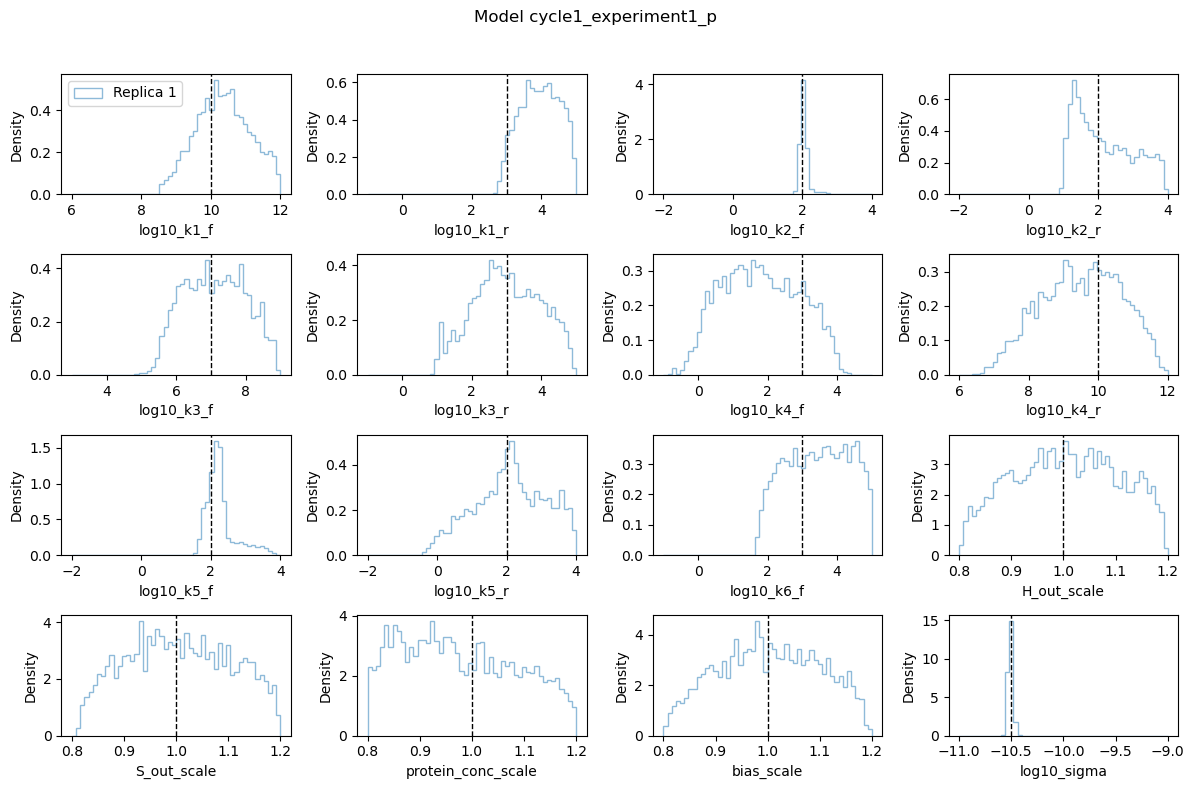

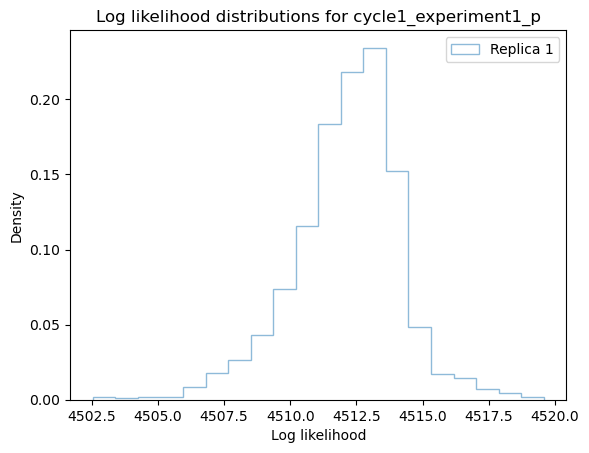

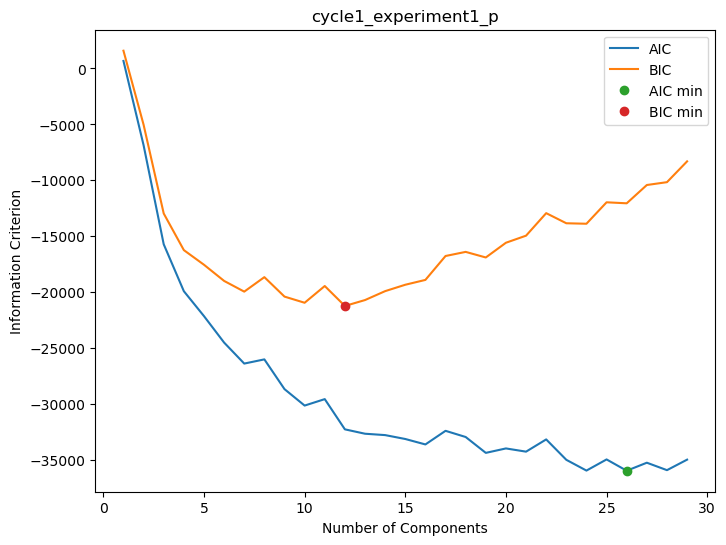

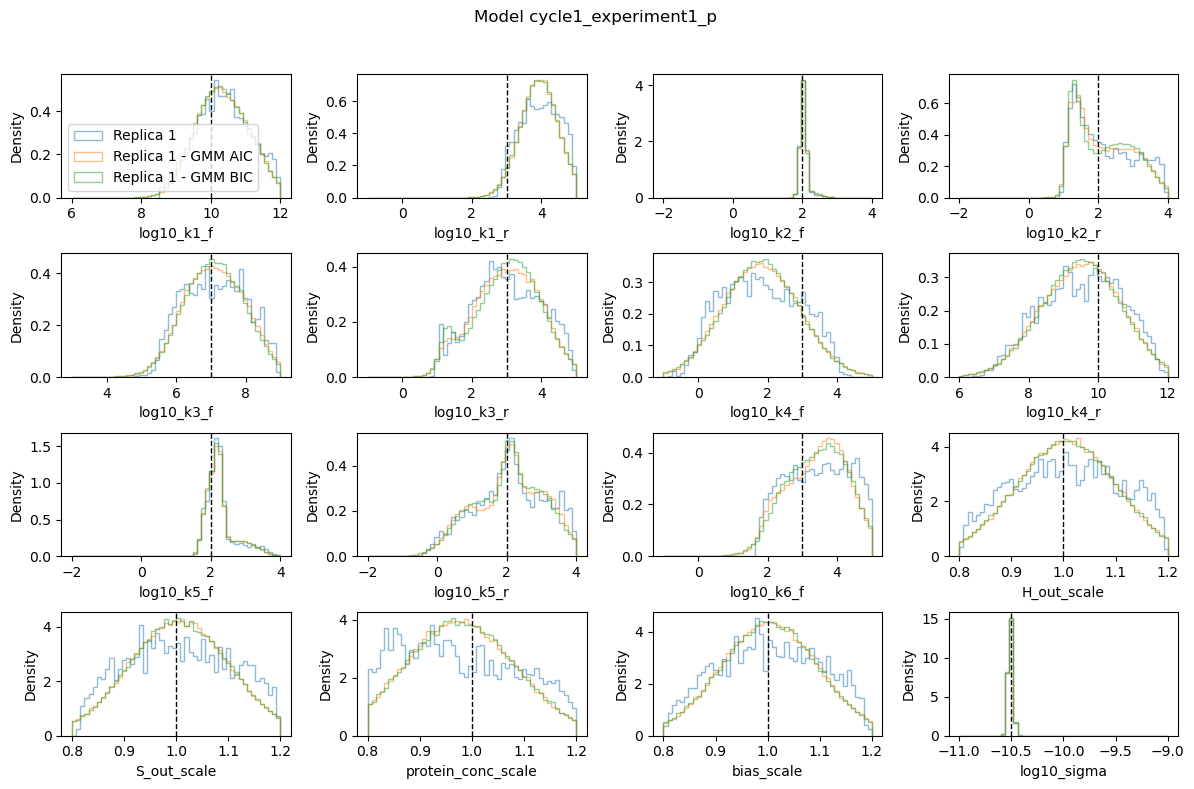

KL divergence of cycle1_experiment1_p = 23.416275433617532
Figure saved as output_figures/cycle1_experiment1and2_sampling_distributions.png
Figure saved as output_figures/cycle1_experiment1and2_corner_plot.png
Figure saved as output_figures/cycle1_experiment1and2_likelihoods.png
Figure saved as output_figures/cycle1_experiment1and2_log_evidence.png


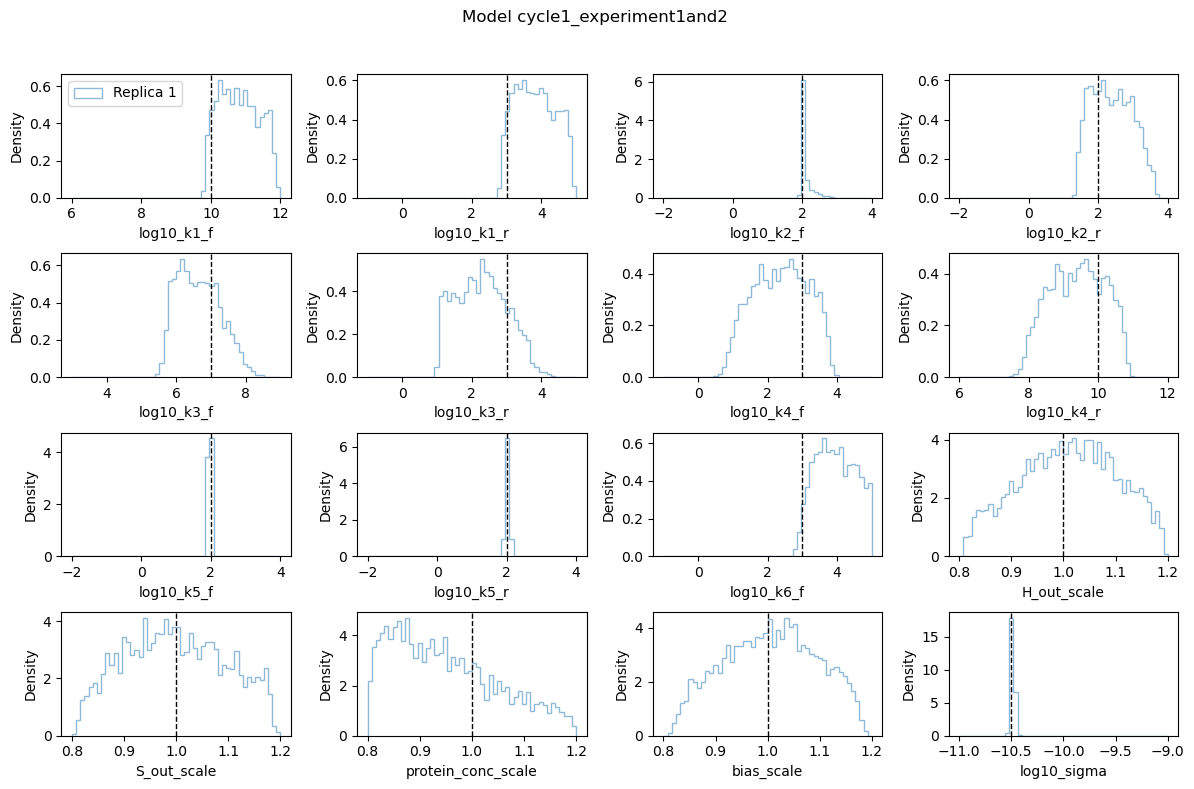

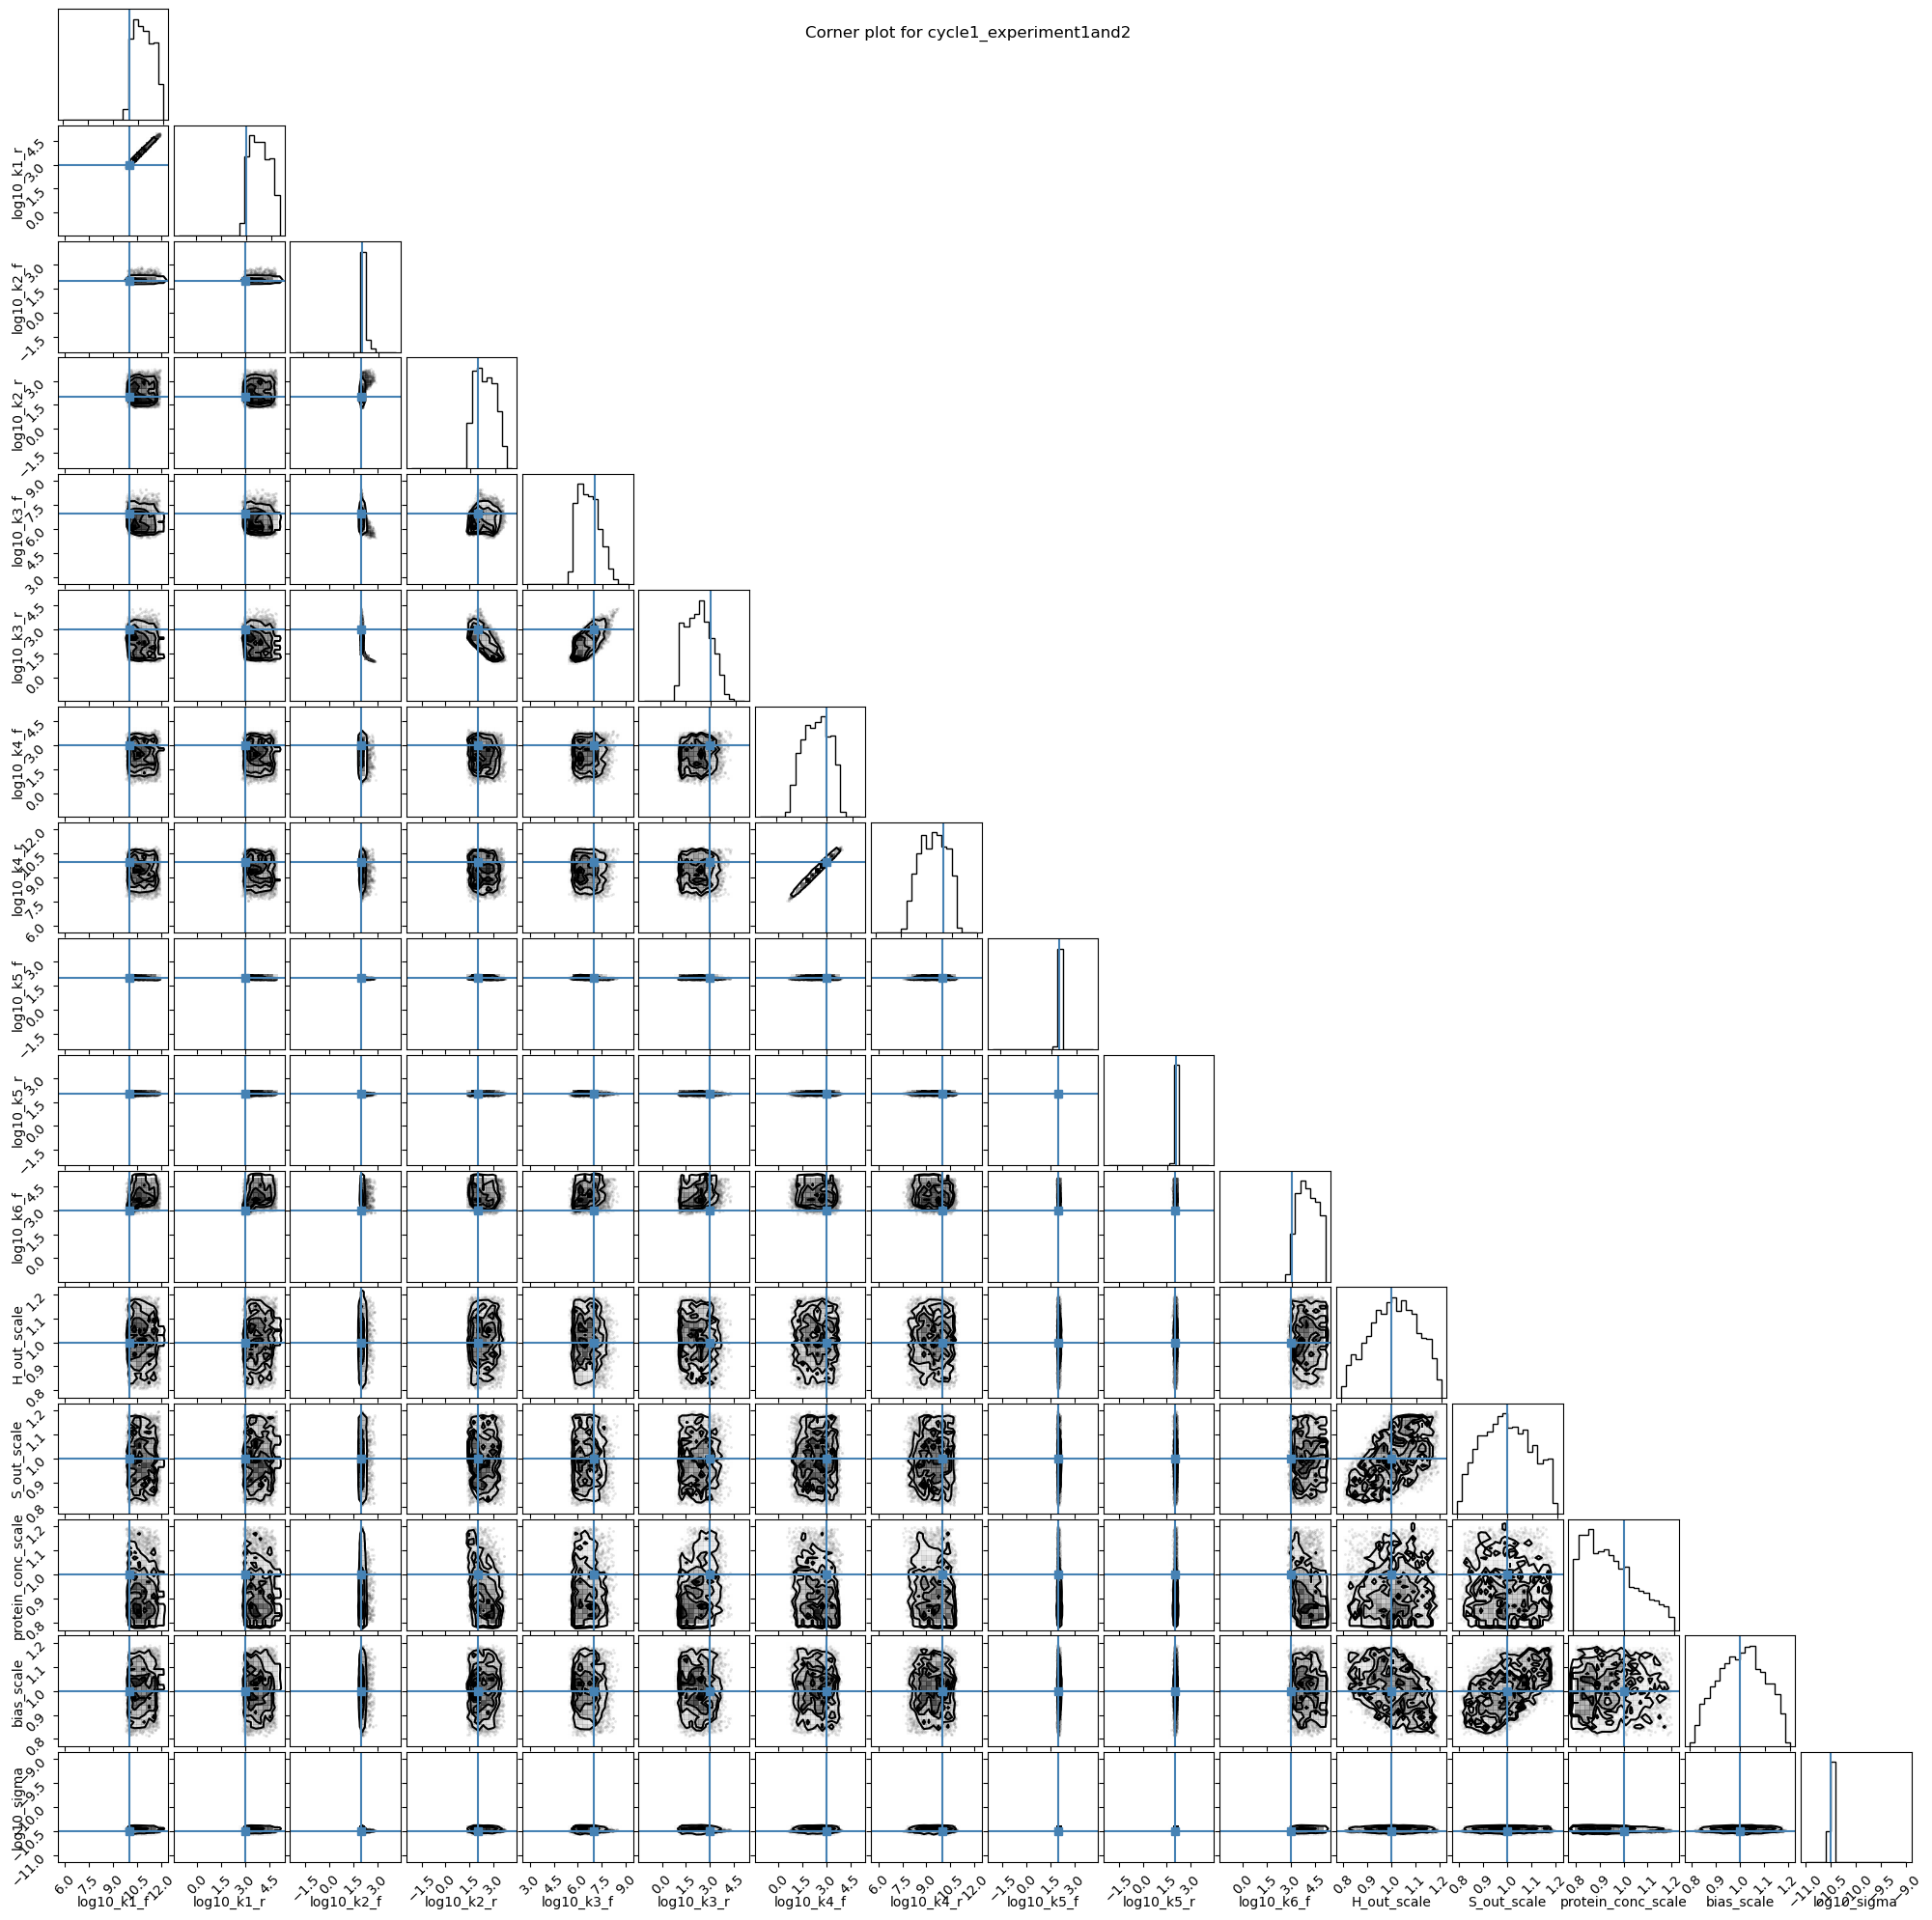

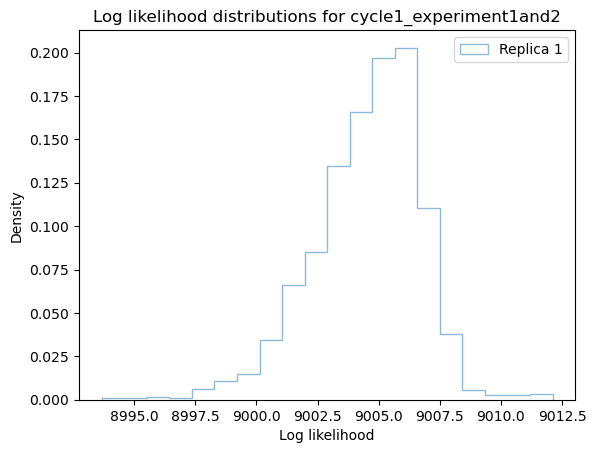

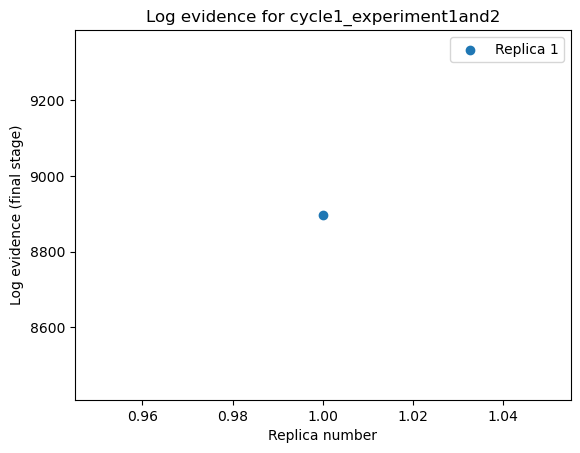

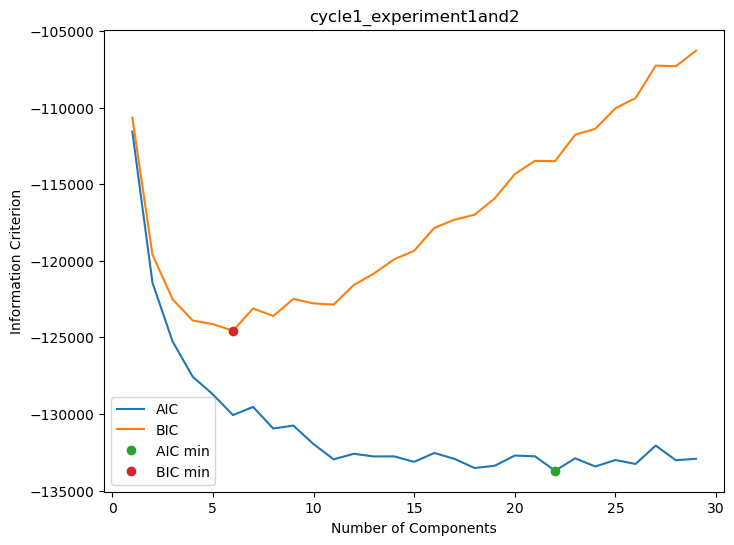

KL divergence of cycle1_experiment1and2 = 38.96943221900815
Figure saved as output_figures/cycle1_4_experiments_sampling_distributions.png
Figure saved as output_figures/cycle1_4_experiments_corner_plot.png
Figure saved as output_figures/cycle1_4_experiments_likelihoods.png
Figure saved as output_figures/cycle1_4_experiments_log_evidence.png


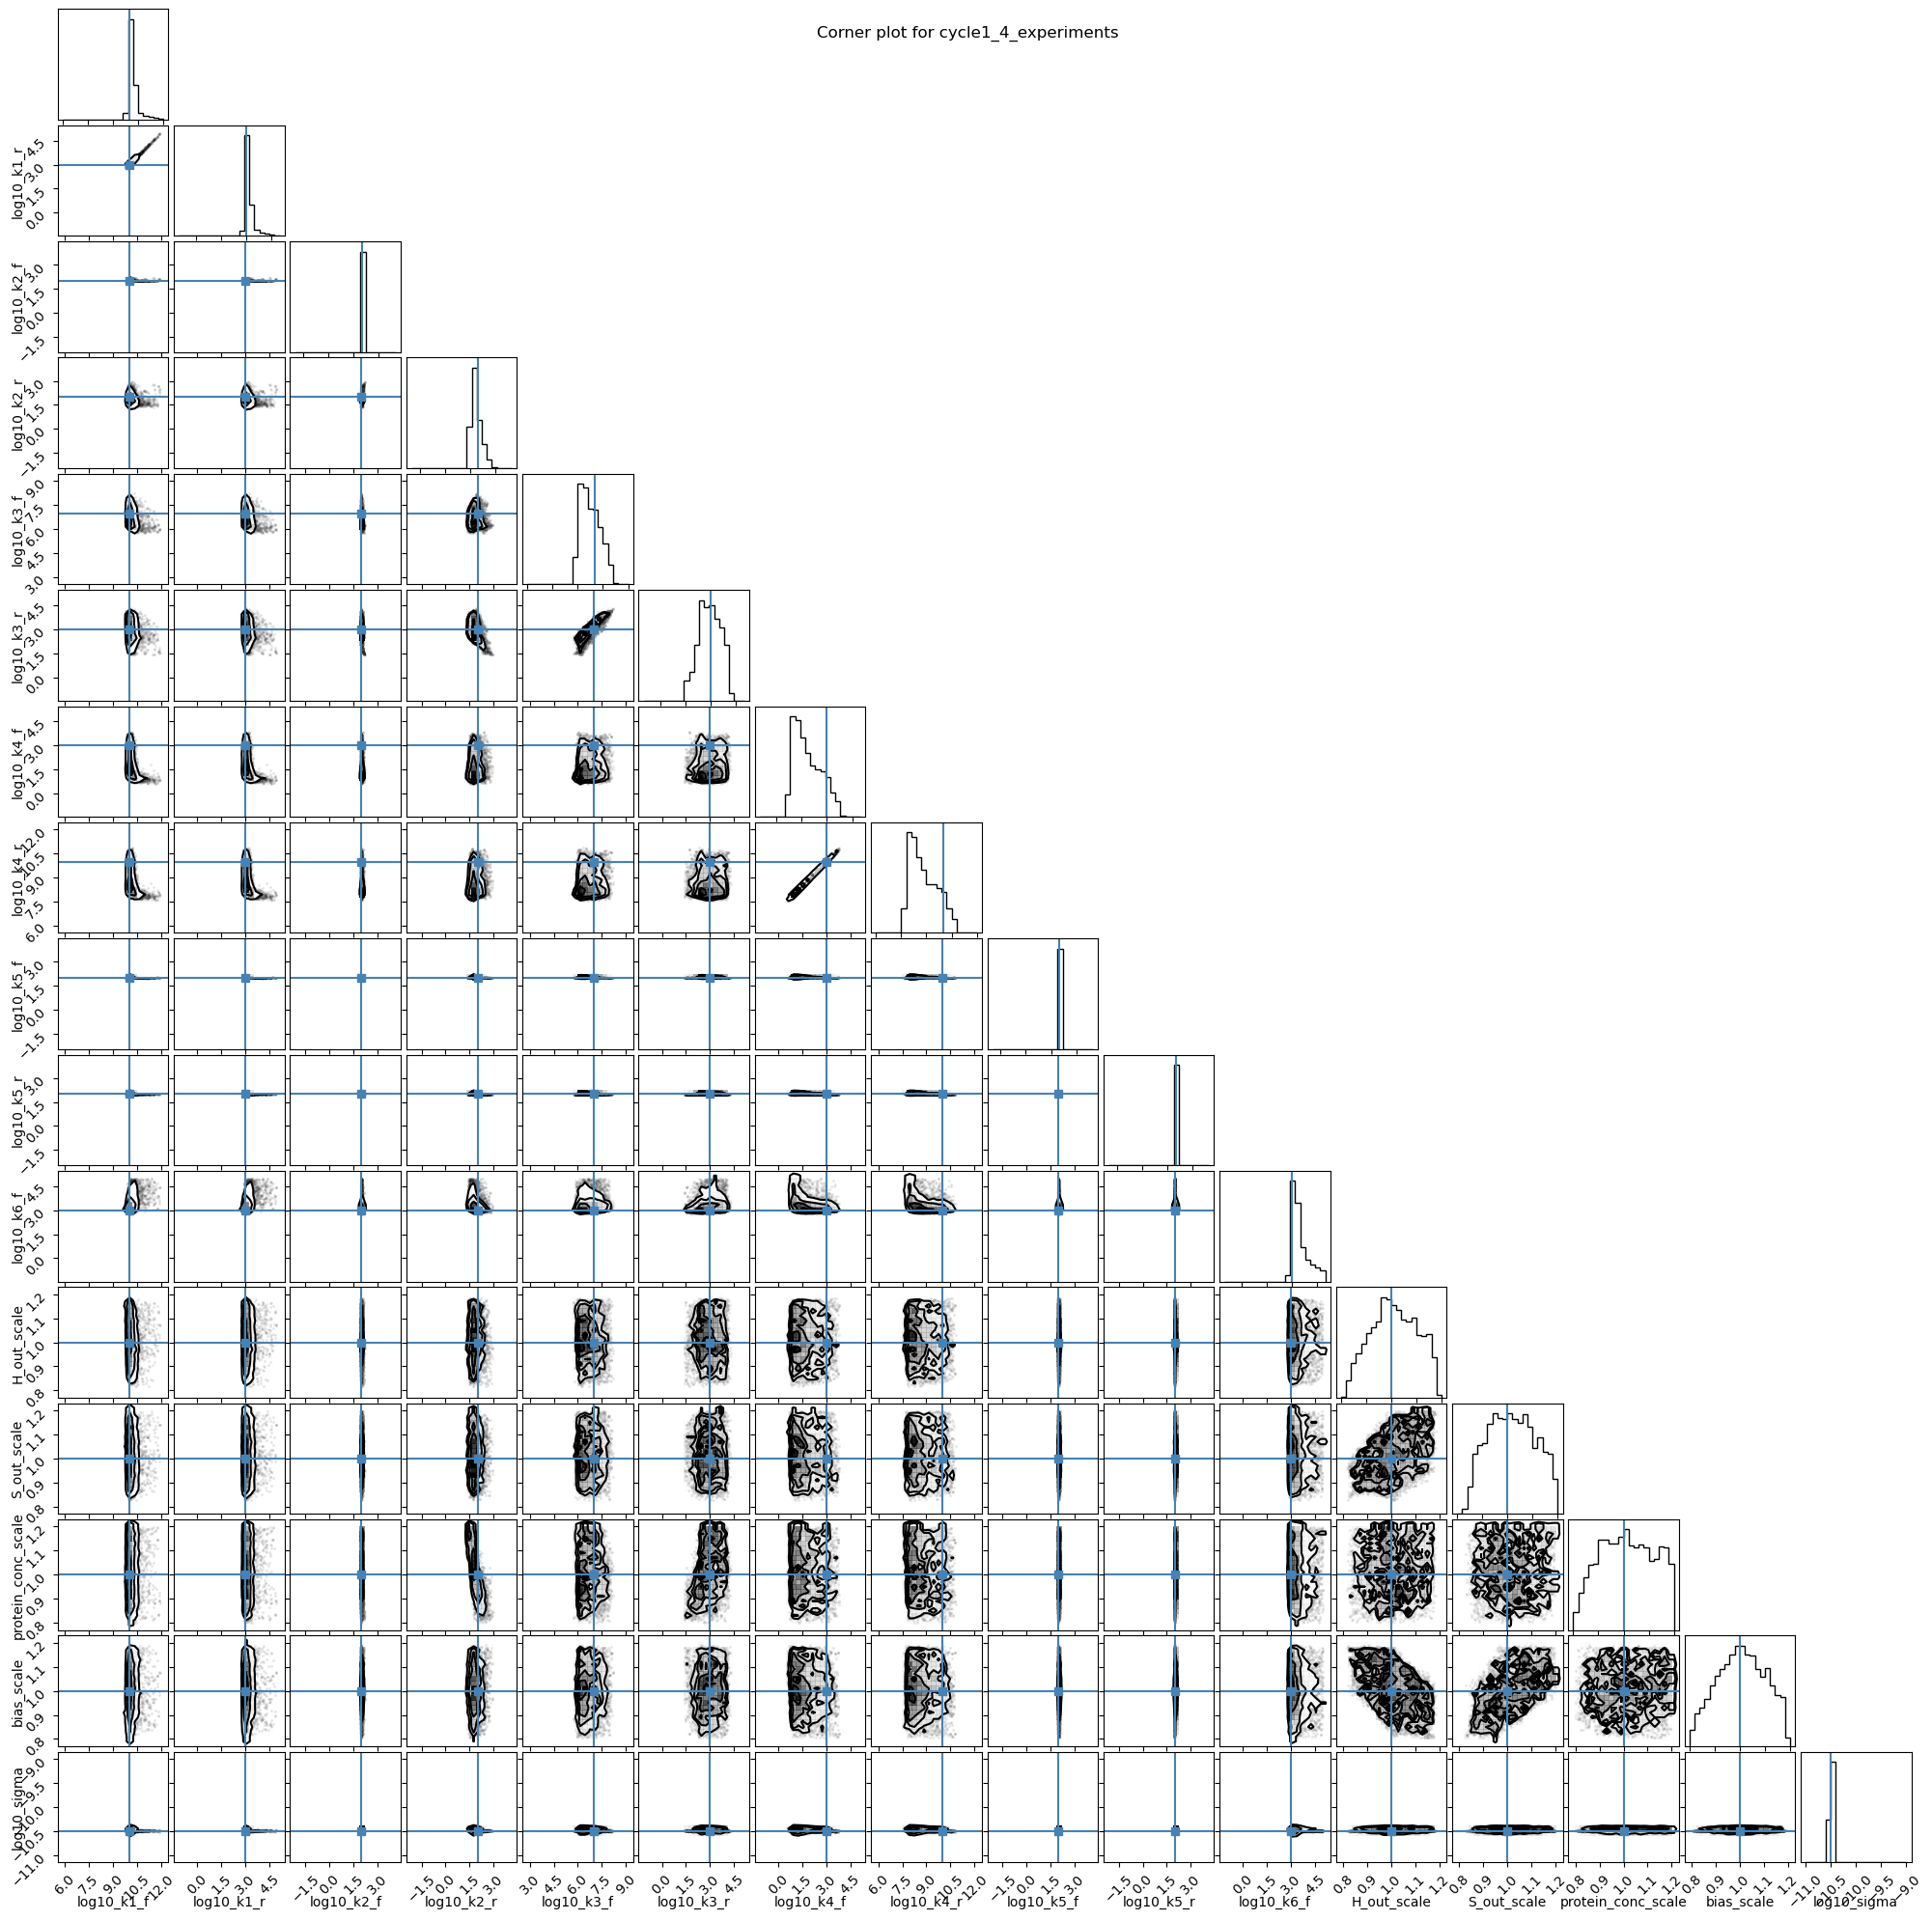

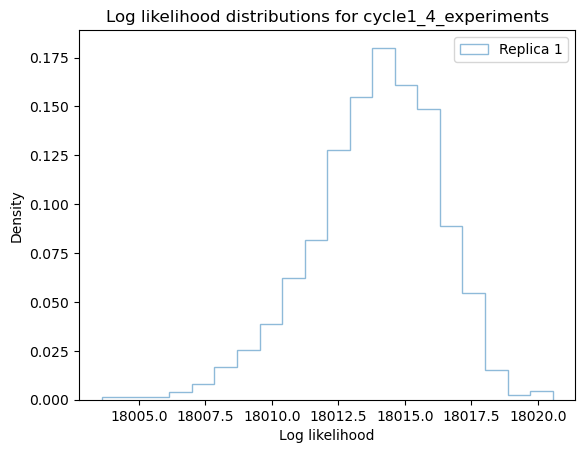

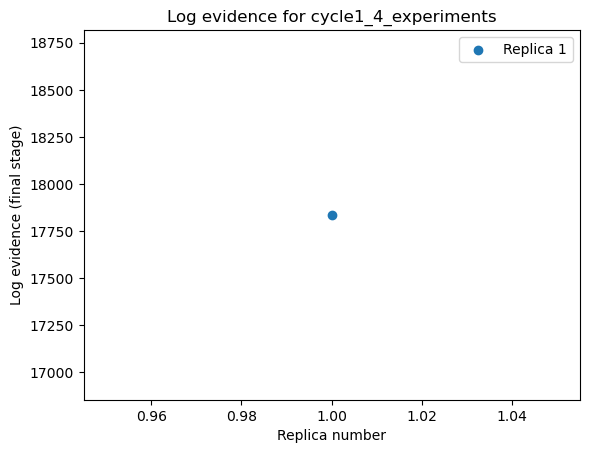

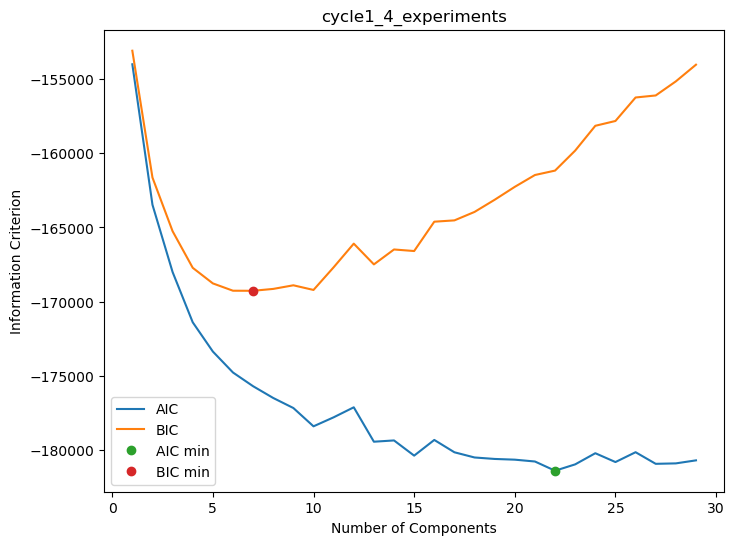

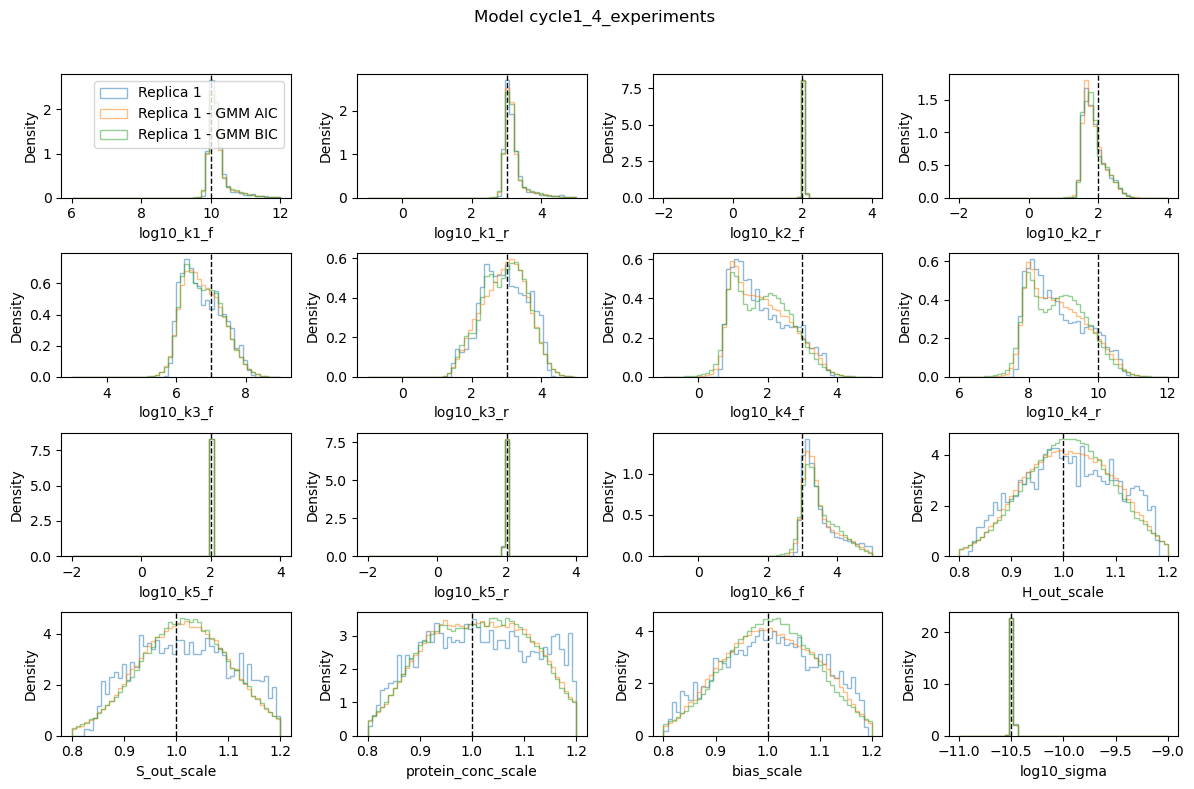

KL divergence of cycle1_4_experiments = 46.221467882845424


In [158]:
import math
import corner
from sklearn.mixture import GaussianMixture
from scipy.stats import uniform
import scipy


output_directory = "output_figures"  # Set the output directory path

# Create the output directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

def save_figure(fig, file_name, output_directory):
    file_path = os.path.join(output_directory, file_name)
    fig.savefig(file_path)
    print(f"Figure saved as {file_path}")


def plot_sampling_distributions(model_name, all_data, parameter_info):
    plt.style.use('default')
    num_bins = 50

    num_replicas = len(all_data[model_name])
    num_parameters = all_data[model_name][0][0].shape[1]

    parameter_names = parameter_info[model_name]['names']
    parameter_ranges = parameter_info[model_name]['ranges']
    parameter_nominals = parameter_info[model_name]['nominals']

    num_cols = math.ceil(math.sqrt(num_parameters))
    num_rows = math.ceil(num_parameters / num_cols)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 2 * num_rows))
    axs = axs.flatten()

    for replica_idx, replica_data in enumerate(all_data[model_name]):
        samples = replica_data[0]

        for param_idx in range(num_parameters):
            axs[param_idx].hist(samples[:, param_idx], bins=num_bins, alpha=0.5, density=True, histtype='step', label=f"Replica {replica_idx + 1}", range=parameter_ranges[param_idx])
            axs[param_idx].axvline(parameter_nominals[param_idx], linestyle='--', color='k', linewidth=1)
            axs[param_idx].set_xlabel(parameter_names[param_idx])
            axs[param_idx].set_ylabel('Density')

    axs[0].legend()
    fig.suptitle(f'Model {model_name}')

    for param_idx in range(num_parameters, num_rows * num_cols):
        fig.delaxes(axs[param_idx])

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    #plt.show()
    return fig


def plot_corner_plot(model_name, all_data, parameter_info):
    parameter_ranges = parameter_info[model_name]['ranges']
    parameter_names = parameter_info[model_name]['names']
    parameter_nominals = parameter_info[model_name]['nominals']
    fig = plt.figure(figsize=(20,20))
    # Generate corner plot
    for replica_idx, replica_data in enumerate(all_data[model_name]):
        samples = replica_data[0]
        corner.corner(samples, labels=parameter_names, range=parameter_ranges, fig=fig, truths=parameter_nominals,plot_contours=True, quiet=True)
    plt.suptitle(f'Corner plot for {model_name}')
    #plt.show()
    return fig

def plot_likelihoods(model_name, all_data):
    # Plot likelihoods
    fig, ax = plt.subplots()
    num_bins = 20
    for replica_idx, replica_data in enumerate(all_data[model_name]):
        ax.hist(replica_data[1], bins=num_bins, alpha=0.5, density=True, histtype='step', label=f"Replica {replica_idx + 1}")
    ax.set_xlabel('Log likelihood')
    ax.set_ylabel('Density')
    ax.legend()
    plt.title(f'Log likelihood distributions for {model_name}')
    #plt.show()
    return fig

def plot_log_evidence(model_name, all_data):
    # Plot log evidence
    fig, ax = plt.subplots()
    for replica_idx, replica_data in enumerate(all_data[model_name]):
        ax.scatter(replica_idx+1, replica_data[2][-1], label=f"Replica {replica_idx + 1}")
    ax.set_xlabel('Replica number')
    ax.set_ylabel('Log evidence (final stage)')
    ax.legend()
    plt.title(f'Log evidence for {model_name}')
    #plt.show()
    return fig


def estimate_multivariate_density_w_GMM(samples, name, parameter_info, model_names, parameter_nominals):
    # List to store the results
    n_components = range(1, 30)  # Change range as necessary
    aics = []
    bics = []
    gmms = []
    

    # Fit GMMs with different numbers of components
    for n in n_components:
        gmm = GaussianMixture(n_components=n, max_iter=1000)
        gmm.fit(samples)
        aics.append(gmm.aic(samples))
        bics.append(gmm.bic(samples))
        gmms.append(gmm)

    # Plot the results
    plt.figure(figsize=(8, 6))
    plt.plot(n_components, aics, label='AIC')
    plt.plot(n_components, bics, label='BIC')
    
    plt.xlabel('Number of Components')
    plt.ylabel('Information Criterion')
    

    gmm_best_bic_idx = np.argmin(bics)
    gmm_best_bic = gmms[gmm_best_bic_idx]
    gmm_best_aic_idx = np.argmin(aics)
    gmm_best_aic = gmms[gmm_best_aic_idx]

    plt.plot(gmm_best_aic_idx+1, aics[gmm_best_aic_idx], 'o', label='AIC min')
    plt.plot(gmm_best_bic_idx+1, bics[gmm_best_bic_idx], 'o', label='BIC min')
    plt.legend()
    plt.title(f'{name}')
    plt.show()
    plt.close()
    return gmm_best_aic, gmm_best_bic



def plot_sampling_distributions_w_GMM(model_name, all_data, parameter_info):
    plt.style.use('default')
    num_bins = 50

    num_replicas = len(all_data[model_name])
    num_parameters = all_data[model_name][0][0].shape[1]

    parameter_names = parameter_info[model_name]['names']
    parameter_ranges = parameter_info[model_name]['ranges']
    parameter_nominals = parameter_info[model_name]['nominals']

    num_cols = math.ceil(math.sqrt(num_parameters))
    num_rows = math.ceil(num_parameters / num_cols)

  

    for replica_idx, replica_data in enumerate(all_data[model_name]):
        samples = replica_data[0]
        GMM_AIC, GMM_BIC = estimate_multivariate_density_w_GMM(samples, model_name, parameter_info, model_names, parameter_nominals)
        n_samples = int(1e5)
        samples_GMM_AIC,_ = GMM_AIC.sample(n_samples)
        samples_GMM_BIC,_ = GMM_BIC.sample(n_samples)

        fig, axs = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 2 * num_rows))
        axs = axs.flatten()
        for param_idx in range(num_parameters):
            axs[param_idx].hist(samples[:, param_idx], bins=num_bins, alpha=0.5, density=True, histtype='step', label=f"Replica {replica_idx + 1}", range=parameter_ranges[param_idx])
            axs[param_idx].hist(samples_GMM_AIC[:, param_idx], bins=num_bins, alpha=0.5, density=True, histtype='step', label=f"Replica {replica_idx + 1} - GMM AIC", range=parameter_ranges[param_idx])
            axs[param_idx].hist(samples_GMM_BIC[:, param_idx], bins=num_bins, alpha=0.5, density=True, histtype='step', label=f"Replica {replica_idx + 1} - GMM BIC", range=parameter_ranges[param_idx])
            axs[param_idx].axvline(parameter_nominals[param_idx], linestyle='--', color='k', linewidth=1)
            axs[param_idx].set_xlabel(parameter_names[param_idx])
            axs[param_idx].set_ylabel('Density')

    axs[0].legend()
    fig.suptitle(f'Model {model_name}')

    for param_idx in range(num_parameters, num_rows * num_cols):
        fig.delaxes(axs[param_idx])
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

    parameter_ranges = parameter_info[model_name]['ranges']
    parameter_names = parameter_info[model_name]['names']
    parameter_nominals = parameter_info[model_name]['nominals']
    
    # # Generate corner plot
    # for replica_idx, replica_data in enumerate(all_data[model_name]):
    #     colors = plt.cm.viridis(np.linspace(0, 1, 3))
    #     samples = replica_data[0]
    #     fig = plt.figure(figsize=(20,20))
    #     corner.corner(samples_GMM_AIC, labels=parameter_names, color=colors[1],  range=parameter_ranges, fig=fig, truths=parameter_nominals,plot_contours=True, quiet=True, alpha=0.75)
    #     corner.corner(samples_GMM_BIC, labels=parameter_names,  color=colors[2], range=parameter_ranges, fig=fig, truths=parameter_nominals,plot_contours=True, quiet=True, alpha=0.75)
    #     corner.corner(samples, labels=parameter_names, color=colors[0], range=parameter_ranges, fig=fig, truths=parameter_nominals,plot_contours=True, quiet=True, alpha=0.75)
    # plt.suptitle(f'Corner plot for {model_name}')
    # # To add a legend, we'll add proxy artists for the colors
    # blue_proxy = plt.Rectangle((10, 10), 1, 1, fc=colors[0])
    # red_proxy = plt.Rectangle((10, 10), 1, 1, fc=colors[1])
    # green_proxy = plt.Rectangle((10, 10), 1, 1, fc=colors[2])

    # # Add the legend
    # fig.legend([blue_proxy, red_proxy, green_proxy], ['Post.', 'GM_AIC', 'GMM_BIC'], loc='upper right')

    # plt.show()

    return GMM_BIC


def kl_divergence_gmm_uniform(model_name, gmm, parameter_info, n_samples=10**6):

    parameter_ranges = parameter_info[model_name]['ranges']

    samples = gmm.sample(n_samples)[0]

    # Filter out samples that are outside the ranges
    valid_samples = np.all([(samples[:, i] >= r[0]) & (samples[:, i] <= r[1]) for i, r in enumerate(parameter_ranges)], axis=0)
    samples = samples[valid_samples]

    # Evaluate the log pdf of the GMM at the sample points
    log_gmm_pdf = gmm.score_samples(samples)

    # Evaluate the log pdf of the uniform distribution at the sample points
    log_uniform_pdf = np.sum([uniform.logpdf(samples[:, i], loc=r[0], scale=r[1]-r[0]) for i, r in enumerate(parameter_ranges)], axis=0)

    # Estimate the KL divergence as the mean of the log pdf ratio
    kl_divergence = np.mean(log_gmm_pdf - log_uniform_pdf)
    print(f"KL divergence of {model_name} = {kl_divergence}")
    return kl_divergence
  
    # Call the functions within the main loop

gmm_list = []
KL_list = []
for model_name in model_names:
    fig = plot_sampling_distributions(model_name, all_data, parameter_info);
    save_figure(fig, f"{model_name}_sampling_distributions.png", output_directory);

    fig = plot_corner_plot(model_name, all_data, parameter_info);
    save_figure(fig, f"{model_name}_corner_plot.png", output_directory);

    fig = plot_likelihoods(model_name, all_data);
    save_figure(fig, f"{model_name}_likelihoods.png", output_directory);

    fig = plot_log_evidence(model_name, all_data);
    save_figure(fig, f"{model_name}_log_evidence.png", output_directory);

    gmm = plot_sampling_distributions_w_GMM(model_name, all_data, parameter_info)
    gmm_list.append(gmm)
    KL_list.append(kl_divergence_gmm_uniform(model_name, gmm, parameter_info, n_samples=10**6))
    




#### comparing models

Figure saved as output_figures/model_comparison_sampling_distributions.png
Figure saved as output_figures/model_comparison_log_likelihood_distributions.png
Figure saved as output_figures/model_comparison_log_evidence_distributions.png
{'cycle1_experiment1_p': [inf], 'cycle1_experiment1and2': [inf]}
Figure saved as output_figures/model_comparison_bayes_factors.png


/var/folders/n9/ypwpwtxs29dgh8ycr8xkgcp0n7tvkv/T/ipykernel_51385/2152515275.py:114: RuntimeWarning:

overflow encountered in exp

/opt/miniconda3/envs/py311_bt/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning:

invalid value encountered in subtract



model cycle1_experiment1_p, replica 0 --> total KL div = 18.038574330919047 bits
[18.038574330919047]
model cycle1_experiment1and2, replica 0 --> total KL div = 29.292511975921418 bits
[18.038574330919047, 29.292511975921418]
model cycle1_4_experiments, replica 0 --> total KL div = 37.10020755808765 bits
[18.038574330919047, 29.292511975921418, 37.10020755808765]
[18.038574330919047, 29.292511975921418, 37.10020755808765]
Figure saved as output_figures/model_comparison_KL_div.png
Figure saved as output_figures/model_comparison_KL_div_summary.png
Figure saved as output_figures/model_comparison_KL_div_summary.png


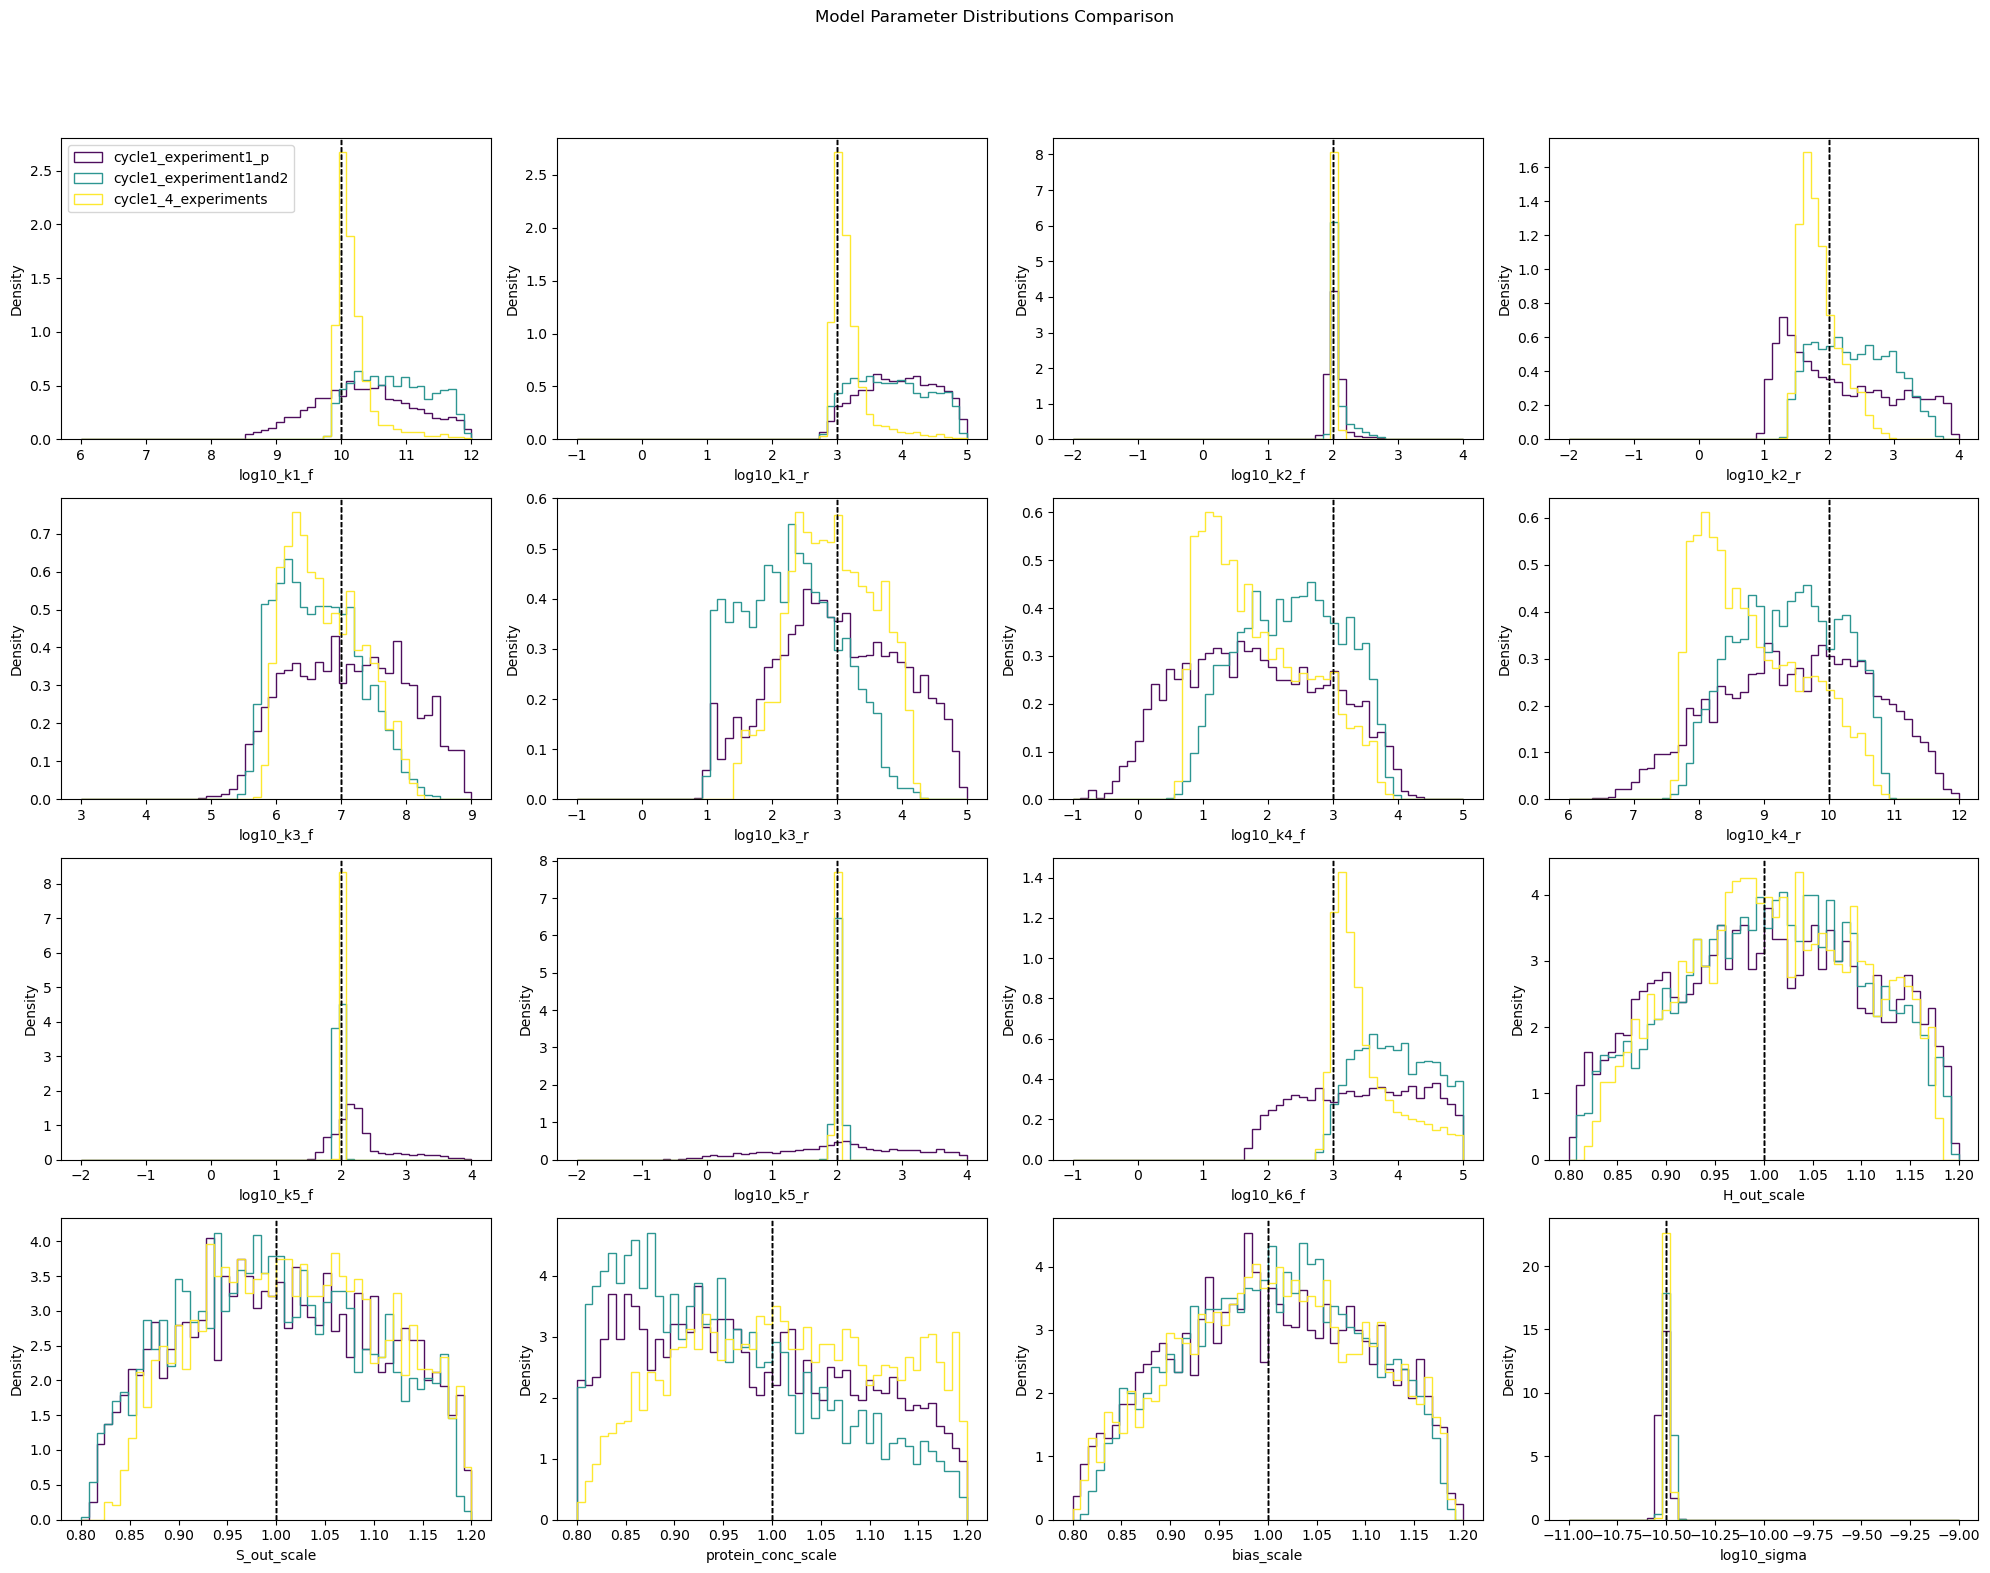

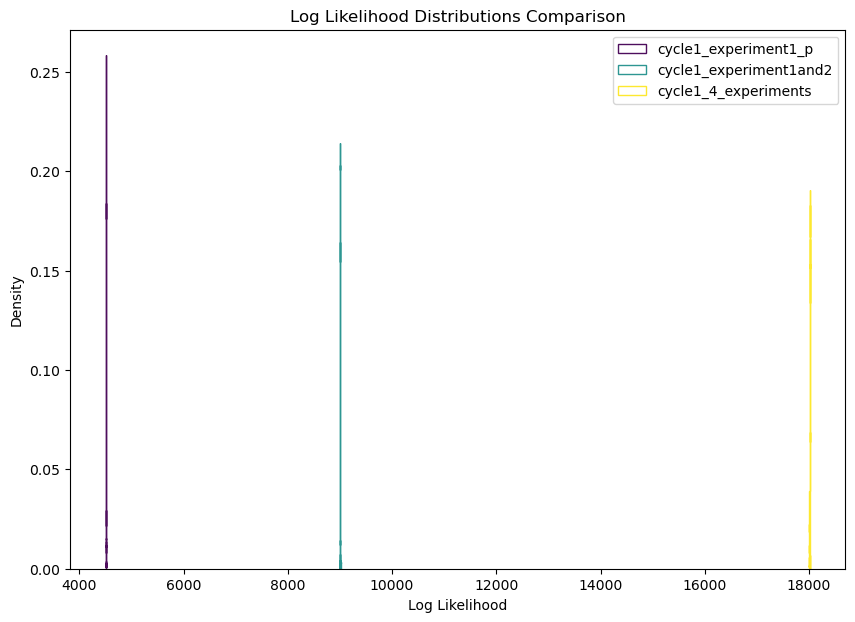

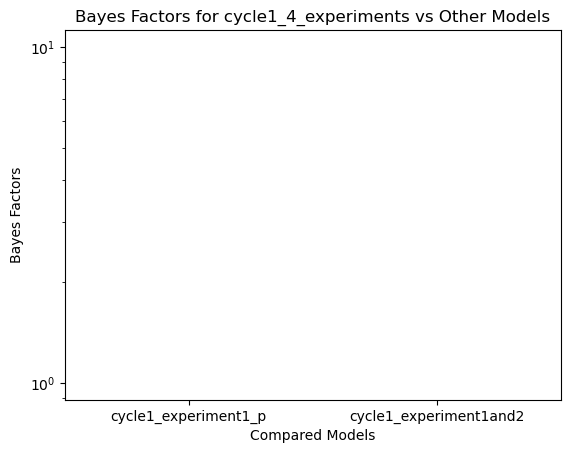

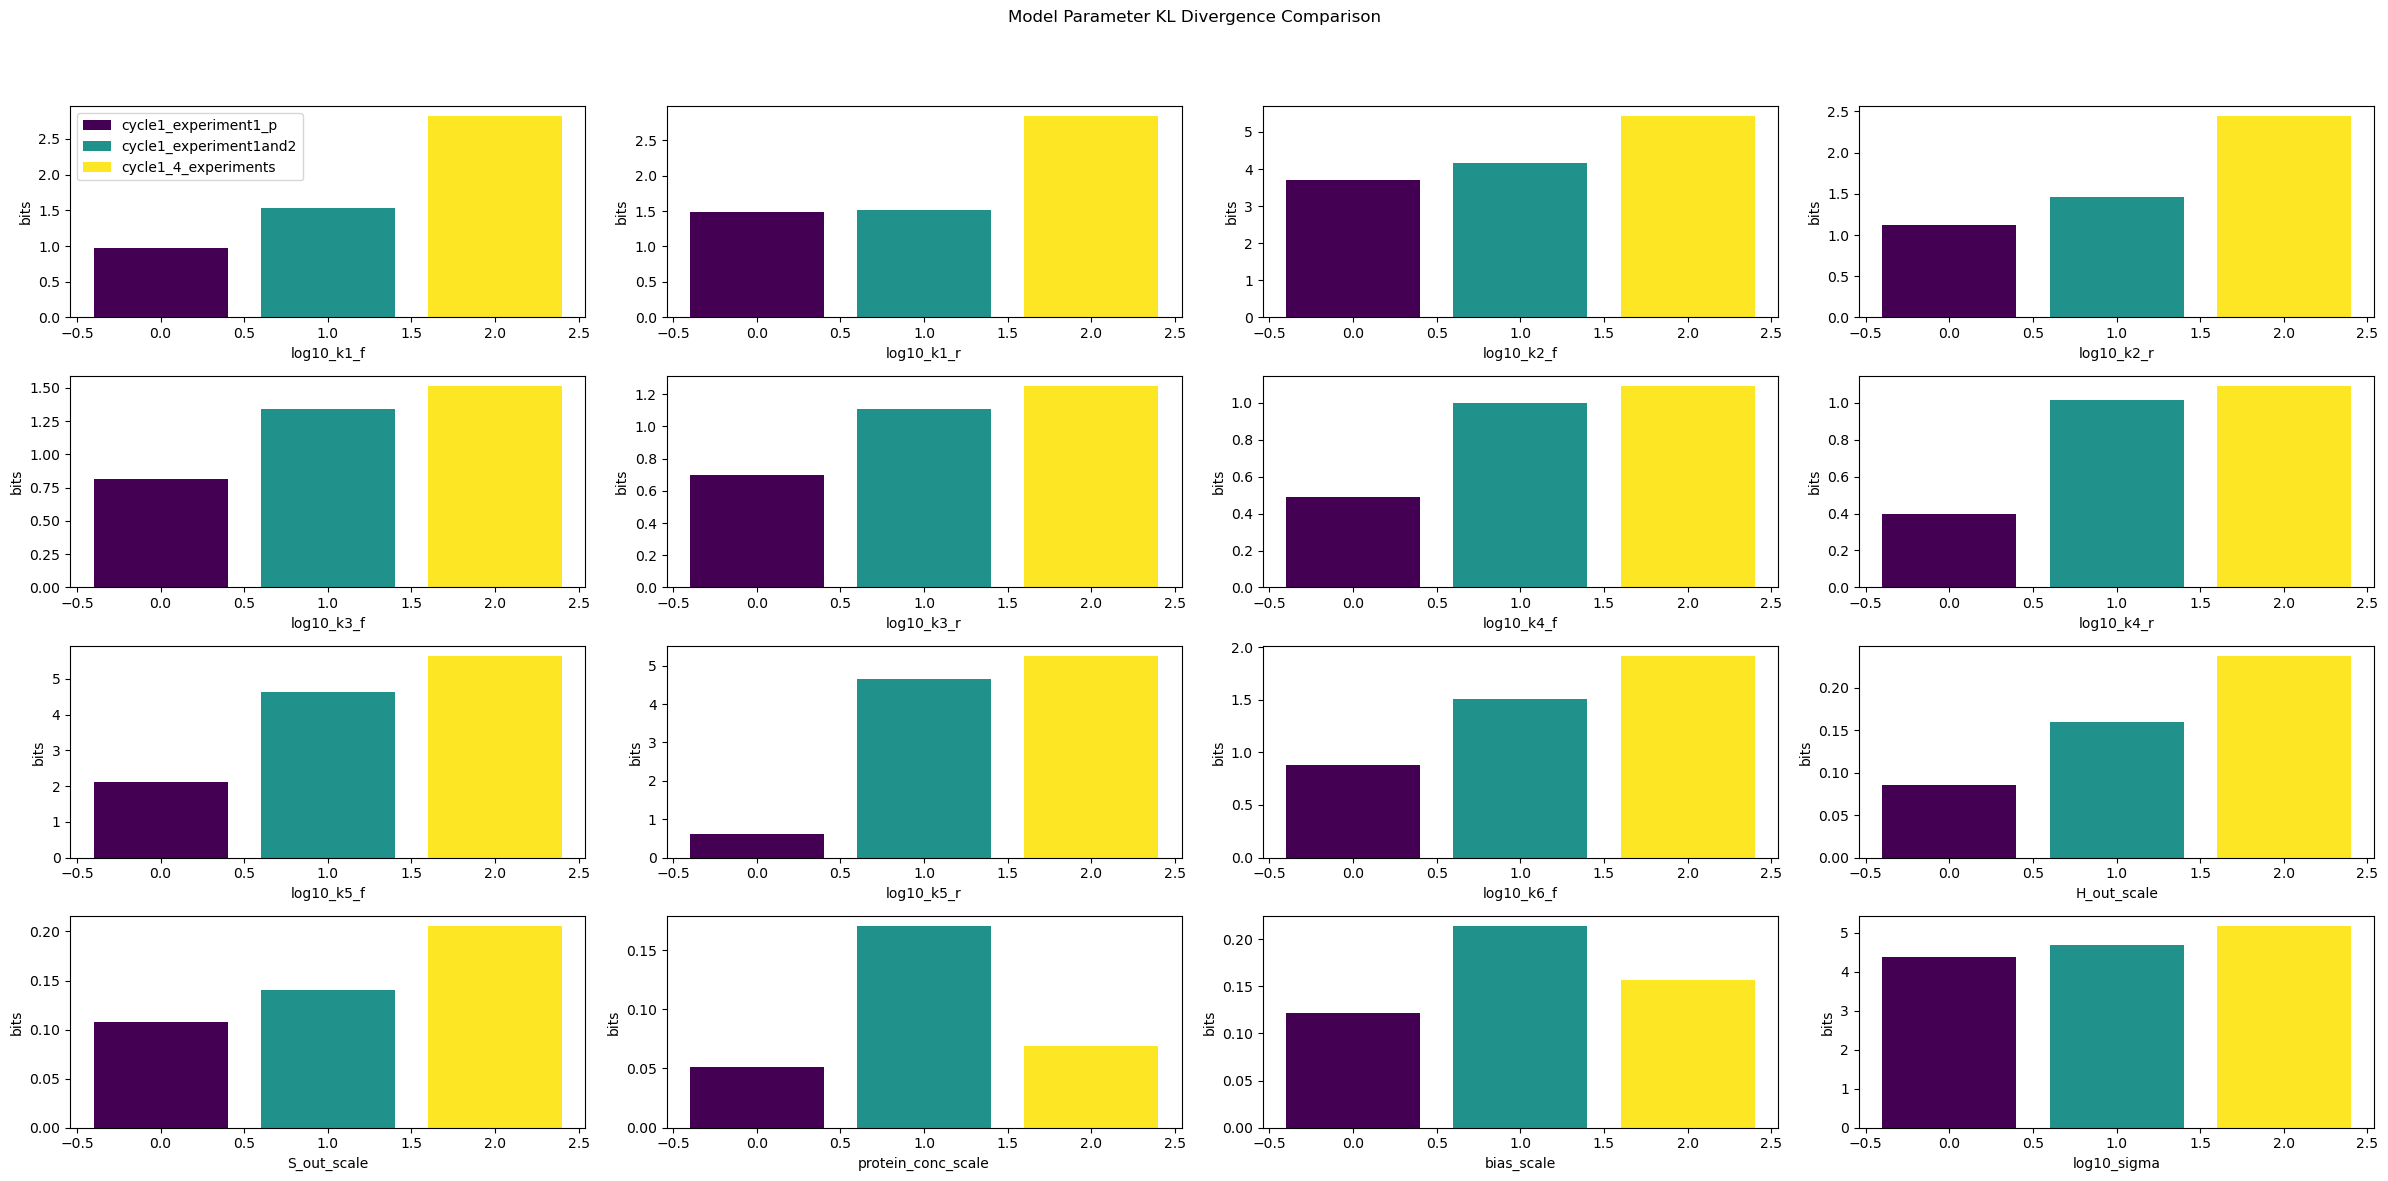

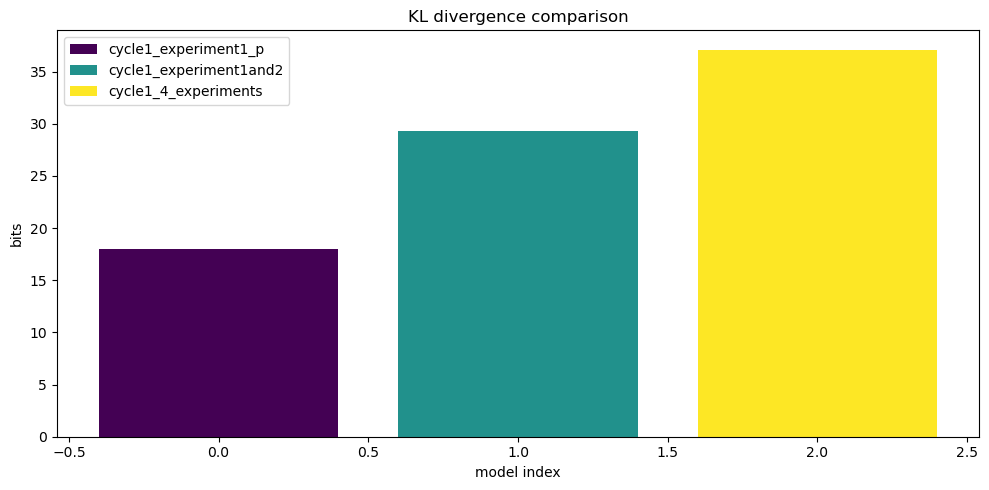

In [159]:
import numpy as np
import seaborn as sns
from matplotlib import cycler
from sklearn.mixture import GaussianMixture

def plot_sampling_distributions_comparison(all_data, parameter_info, model_names, parameter_nominals):
    #plt.style.use('default')
    num_bins = 50

    model_parameters = {model_name: all_data[model_name][0][0].shape[1] for model_name in model_names}
    max_num_parameters = max(model_parameters.values())

    num_cols = math.ceil(math.sqrt(max_num_parameters))
    num_rows = math.ceil(max_num_parameters / num_cols)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows))
    axs = axs.flatten()

    colors = plt.cm.viridis(np.linspace(0, 1, len(model_names)))

    for model_idx, model_name in enumerate(model_names):
        num_replicas = len(all_data[model_name])
        num_parameters = all_data[model_name][0][0].shape[1]

        parameter_names = parameter_info[model_name]['names']
        parameter_ranges = parameter_info[model_name]['ranges']
        #parameter_nominals = parameter_info[model_name]['nominals']

        for replica_idx, replica_data in enumerate(all_data[model_name]):
            samples = replica_data[0]

            for param_idx in range(num_parameters):
                if replica_idx == 0:
                    label = f"{model_name}"
                else:
                    label = None
                axs[param_idx].hist(samples[:, param_idx], bins=num_bins, alpha=0.95, density=True, histtype='step', color=colors[model_idx], label=label, range=parameter_ranges[param_idx])
                axs[param_idx].axvline(parameter_nominals[param_idx], linestyle='--', color='k', linewidth=1)
                axs[param_idx].set_xlabel(parameter_names[param_idx])
                axs[param_idx].set_ylabel('Density')

    axs[0].legend()
    fig.suptitle('Model Parameter Distributions Comparison')

    for param_idx in range(max_num_parameters, num_rows * num_cols):
        fig.delaxes(axs[param_idx])

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    return fig


def plot_likelihoods_comparison(all_data, model_names):
    fig, ax = plt.subplots(figsize=(10,7))

    colors = plt.cm.viridis(np.linspace(0, 1, len(model_names)))

    max_logl = 0
    for model_idx, model_name in enumerate(model_names):
        for replica_idx, replica_data in enumerate(all_data[model_name]):
            if np.max(replica_data[1]) > max_logl:
                max_logl = np.max(replica_data[1])
            if replica_idx == 0:
                label = f"{model_name}"
            else:
                label = None
            ax.hist(replica_data[1], bins=50, alpha=0.95, density=True, histtype='step', color=colors[model_idx], label=label)

    ax.set_xlabel('Log Likelihood')
    ax.set_ylabel('Density')
    #ax.set_xlim(0.9*max_logl, 1.1*max_logl)
    ax.legend()
    plt.title('Log Likelihood Distributions Comparison')
    return fig


def plot_log_evidence_comparison(all_data, model_names):
    fig, ax = plt.subplots(figsize=(10,7))

    colors = plt.cm.viridis(np.linspace(0, 1, len(model_names)))

    for model_idx, model_name in enumerate(model_names):
        for replica_idx, replica_data in enumerate(all_data[model_name]):
            if replica_idx == 0:
                label = f"{model_name}"
            else:
                label = None
            ax.scatter(model_idx + 1, replica_data[2][-1], color=colors[model_idx], label=label)

    ax.set_xlabel('Model')
    ax.set_ylabel('Log Evidence (final stage)')
    ax.legend()
    plt.title('Log evidence Comparison')

    # Set the x-axis ticks and labels
    ax.set_xticks(range(1, len(model_names) + 1))
    ax.set_xticklabels(model_names)
    return fig

def calculate_bayes_factors(all_data, model_names, model_a):
    bayes_factors = {}

    for model_name in model_names:
        if model_name != model_a:
            bayes_factors[model_name] = []

    for replica_a_idx, replica_a_data in enumerate(all_data[model_a]):
        log_evidence_a = replica_a_data[2][-1]

        for model_name in model_names:
            if model_name != model_a:
                for replica_b_idx, replica_b_data in enumerate(all_data[model_name]):
                    log_evidence_b = replica_b_data[2][-1]
                    bayes_factor = np.exp(log_evidence_a - log_evidence_b)
                    bayes_factors[model_name].append(bayes_factor)
    return bayes_factors


def plot_bayes_factors(bayes_factors, model_a):
    fig, ax = plt.subplots()
    model_names = list(bayes_factors.keys())
    bayes_factors_values = [bayes_factors[model_name] for model_name in model_names]

    ax.boxplot(bayes_factors_values)
    ax.set_xticklabels(model_names)
    ax.set_xlabel('Compared Models')
    ax.set_ylabel('Bayes Factors')
    ax.set_title(f'Bayes Factors for {model_a} vs Other Models')
    ax.set_yscale("log") 

    # Overlay the scatter plot
    for model_idx, model_name in enumerate(model_names):
        y = bayes_factors[model_name]
        x = np.random.normal(model_idx + 1, 0.04, size=len(y))  # Add jitter along x-axis for better visibility
        ax.scatter(x, y, alpha=0.6)   
    
    return fig


def calc_and_plot_KL_divergence(all_data, parameter_info, model_names, parameter_nominals):
    def kl_divergence_from_uniform(histogram):
        # uniform distribution
        uniform_dist = np.ones(len(histogram)) / len(histogram)
    
        # ensure histogram is normalized
        histogram = histogram / np.sum(histogram)
        
        # Only include non-zero terms in the summation
        mask = histogram > 0
        return np.sum(histogram[mask] * np.log2(histogram[mask] / uniform_dist[mask]))

    num_bins = 50

    model_parameters = {model_name: all_data[model_name][0][0].shape[1] for model_name in model_names}
    max_num_parameters = max(model_parameters.values())

    num_cols = math.ceil(math.sqrt(max_num_parameters))
    num_rows = math.ceil(max_num_parameters / num_cols)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 3 * num_rows))
    axs = axs.flatten()

    colors = plt.cm.viridis(np.linspace(0, 1, len(model_names)))

    KL_model_list = []
    for model_idx, model_name in enumerate(model_names):
        num_replicas = len(all_data[model_name])
        num_parameters = all_data[model_name][0][0].shape[1]

        parameter_names = parameter_info[model_name]['names']
        parameter_ranges = parameter_info[model_name]['ranges']
        #parameter_nominals = parameter_info[model_name]['nominals']
        
        for replica_idx, replica_data in enumerate(all_data[model_name]):

            samples = replica_data[0]
            KL_replica_parameters = []
            KL_replica = 0

            for param_idx in range(num_parameters):
                if replica_idx == 0:
                    label = f"{model_name}"
                else:
                    label = None
                hist, bin_edges = np.histogram(samples[:, param_idx], bins=num_bins,  density=True, range=parameter_ranges[param_idx])
                KL_div = kl_divergence_from_uniform(hist)
                KL_replica_parameters.append(KL_div)
                axs[param_idx].bar(model_idx, KL_div, color=colors[model_idx], label=label)
                axs[param_idx].set_xlabel(parameter_names[param_idx])
                axs[param_idx].set_ylabel('bits')
            KL_replica = np.sum(KL_replica_parameters)
            print(f"model {model_name}, replica {replica_idx} --> total KL div = {KL_replica} bits")
        KL_model_list.append(KL_replica)
        print(KL_model_list)
        

    axs[0].legend()
    fig.suptitle('Model Parameter KL Divergence Comparison')

    for param_idx in range(max_num_parameters, num_rows * num_cols):
        fig.delaxes(axs[param_idx])

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    print(KL_model_list)
    return fig, KL_model_list


def plot_KL_list(KL_list, model_names):
    
    fig = plt.figure(figsize=(10,5))
    colors = plt.cm.viridis(np.linspace(0, 1, len(model_names)))
    for model_idx, model_name in enumerate(model_names):
        plt.bar(model_idx, KL_list[model_idx],  color=colors[model_idx], label=model_name)
    plt.xlabel('model index')
    plt.ylabel('bits')
    plt.title('KL divergence comparison')
    plt.legend()
    plt.tight_layout()
    return fig



def estimate_multivariate_density_w_GMM(samples, name, parameter_info, model_names, parameter_nominals):
    # List to store the results
    n_components = range(1, 30)  # Change range as necessary
    aics = []
    bics = []
    gmms = []
    

    # Fit GMMs with different numbers of components
    for n in n_components:
        gmm = GaussianMixture(n_components=n, max_iter=1000)
        gmm.fit(samples)
        aics.append(gmm.aic(samples))
        bics.append(gmm.bic(samples))
        gmms.append(gmm)

    # Plot the results
    plt.figure(figsize=(8, 6))
    plt.plot(n_components, aics, label='AIC')
    plt.plot(n_components, bics, label='BIC')
    
    plt.xlabel('Number of Components')
    plt.ylabel('Information Criterion')
    

    gmm_best_bic_idx = np.argmin(bics)
    gmm_best_bic = gmms[gmm_best_bic_idx]
    gmm_best_aic_idx = np.argmin(aics)
    gmm_best_aic = gmms[gmm_best_aic_idx]

    plt.plot(gmm_best_aic_idx+1, aics[gmm_best_aic_idx], 'o', label='AIC min')
    plt.plot(gmm_best_bic_idx+1, bics[gmm_best_bic_idx], 'o', label='BIC min')
    plt.legend()
    plt.title(f'{name}')
    plt.show()


    
def compare_density_estimations(all_data, parameter_info, model_names, parameter_nominals):
    #plt.style.use('default')
    num_bins = 50

    model_parameters = {model_name: all_data[model_name][0][0].shape[1] for model_name in model_names}
    max_num_parameters = max(model_parameters.values())

    num_cols = math.ceil(math.sqrt(max_num_parameters))
    num_rows = math.ceil(max_num_parameters / num_cols)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows))
    axs = axs.flatten()

    colors = plt.cm.viridis(np.linspace(0, 1, len(model_names)))

    for model_idx, model_name in enumerate(model_names):
        num_replicas = len(all_data[model_name])
        num_parameters = all_data[model_name][0][0].shape[1]

        parameter_names = parameter_info[model_name]['names']
        parameter_ranges = parameter_info[model_name]['ranges']
        #parameter_nominals = parameter_info[model_name]['nominals']

        for replica_idx, replica_data in enumerate(all_data[model_name]):
            samples = replica_data[0]

            estimate_multivariate_density_w_GMM(samples, model_name, parameter_info, model_names, parameter_nominals)


plt.rcParams['image.cmap'] = 'tab10'

# Call the comparison functions
ref_values = parameter_info['cycle1_4_experiments']['nominals']
fig = plot_sampling_distributions_comparison(all_data,parameter_info, model_names, ref_values)
save_figure(fig, f"model_comparison_sampling_distributions.png", output_directory);
fig = plot_likelihoods_comparison(all_data, model_names)
save_figure(fig, f"model_comparison_log_likelihood_distributions.png", output_directory);
fig = plot_log_evidence_comparison(all_data, model_names)
save_figure(fig, f"model_comparison_log_evidence_distributions.png", output_directory);

# bayes factor comparison
model_a = "cycle1_4_experiments"
bayes_factors = calculate_bayes_factors(all_data, model_names, model_a)
print(bayes_factors)

# Call the plot_bayes_factors function
fig = plot_bayes_factors(bayes_factors, model_a)
save_figure(fig, f"model_comparison_bayes_factors.png", output_directory);

fig, KL_list_1D = calc_and_plot_KL_divergence(all_data,parameter_info, model_names, ref_values)
save_figure(fig, f"model_comparison_KL_div_1D.png", output_directory);

fig = plot_KL_list(KL_list_1D, model_names)
save_figure(fig, f"model_comparison_KL_div_summary_1D.png", output_directory);

fig = plot_KL_list(KL_list, model_names)
save_figure(fig, f"model_comparison_KL_div_summary.png", output_directory);



#### membrane voltage


2.13.2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.3561924999999996e-16
2.3561924999999997e-05
3.449956375265695e-10
0.001: -4.5462251584084725e-09 3.3759704077185894e-09
0.001: 4.151444702756522e-23
0.01: -4.546182535043659e-09 3.375950227958365e-09
0.01: 4.1514447027565457e-23
0.1: -4.545756342256433e-09 3.375748442351988e-09
0.1: 4.1514447027565316e-23
1.0: -4.54149871508868e-09 3.3737317865305878e-09
1.0: 4.151444702756545e-23
10.0: -4.499348321588114e-09 3.3536844037060757e-09
10.0: 4.1514447027565416e-23
100.0: -4.116564181764653e-09 3.164453166446557e-09
100.0: 4.1514447027565363e-23
1000.0: -2.2150159533792892e-09 1.9763704354347846e-09
1000.0: 4.1514447027565516e-23


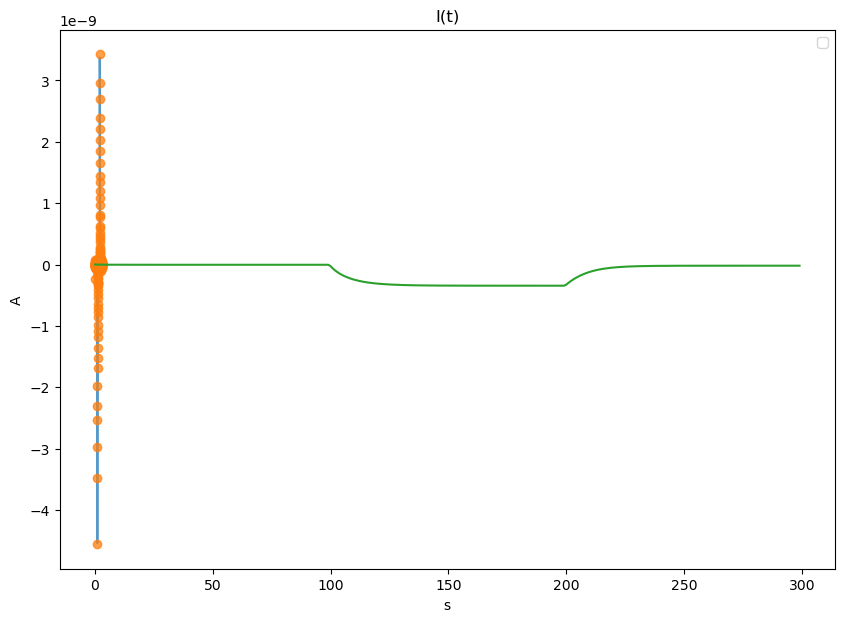

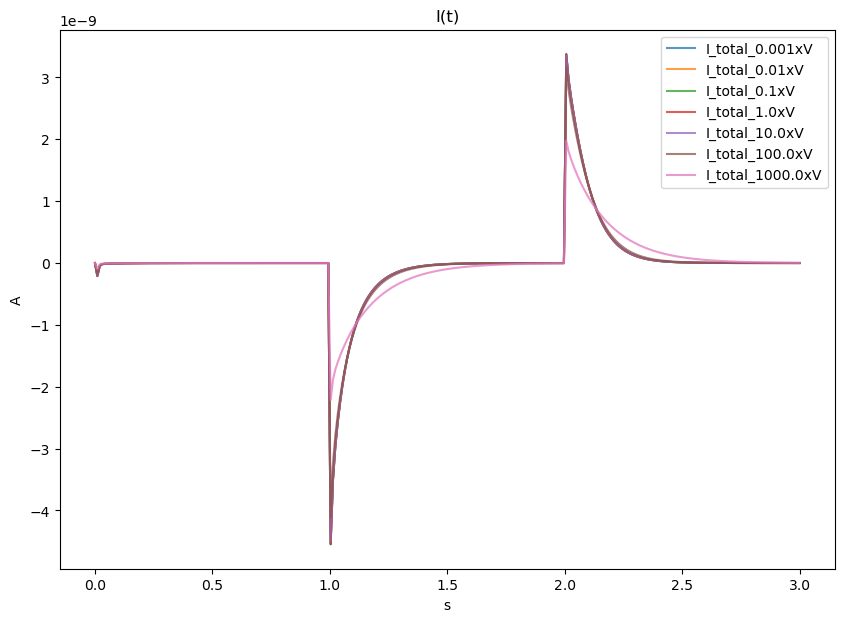

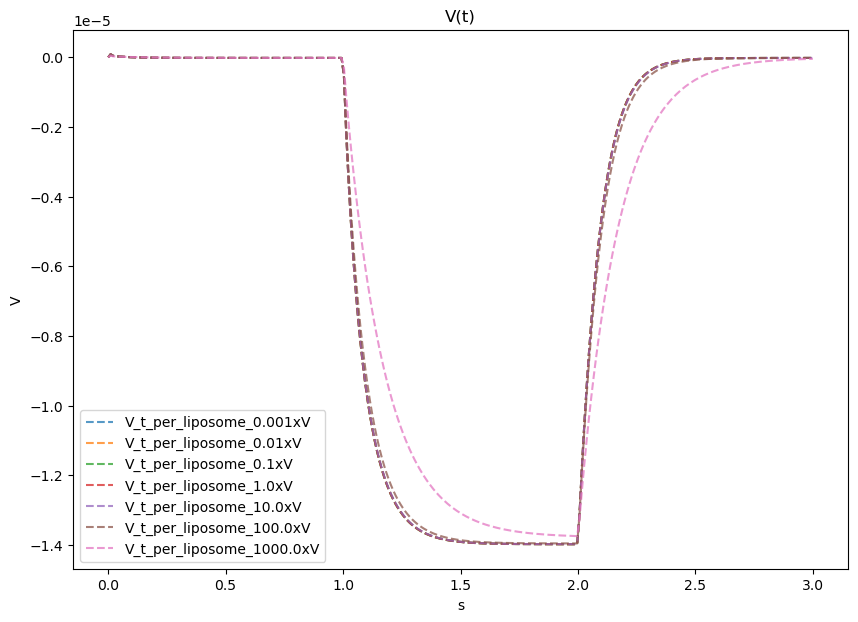

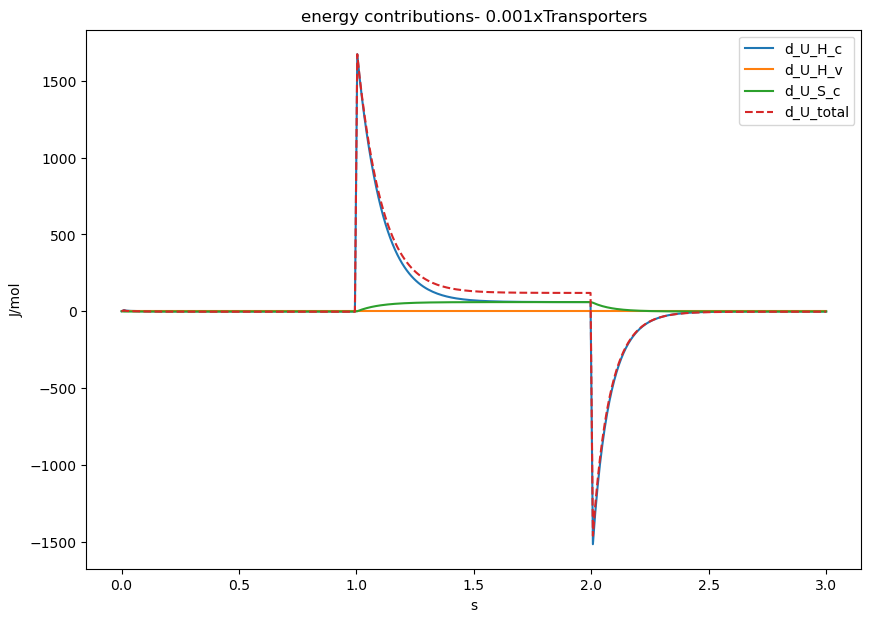

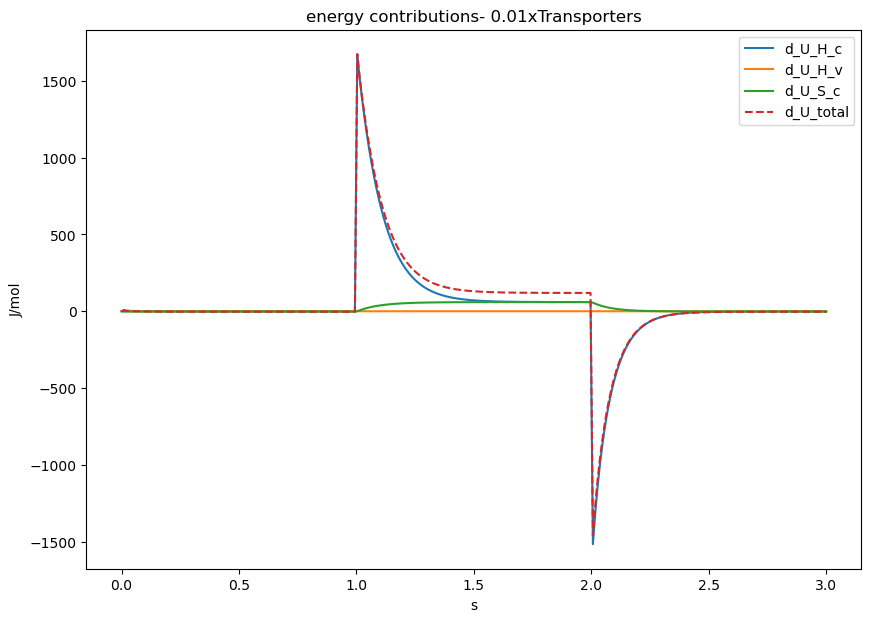

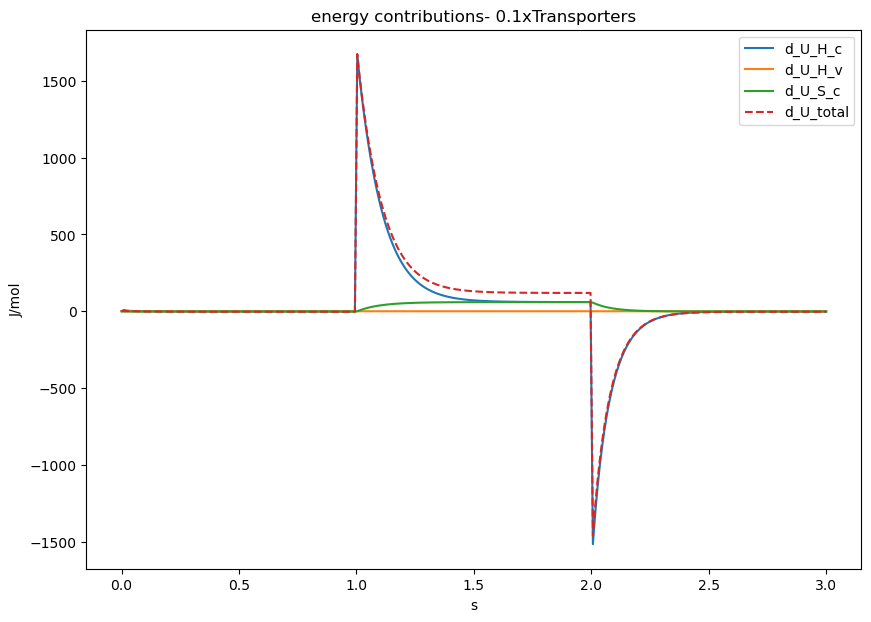

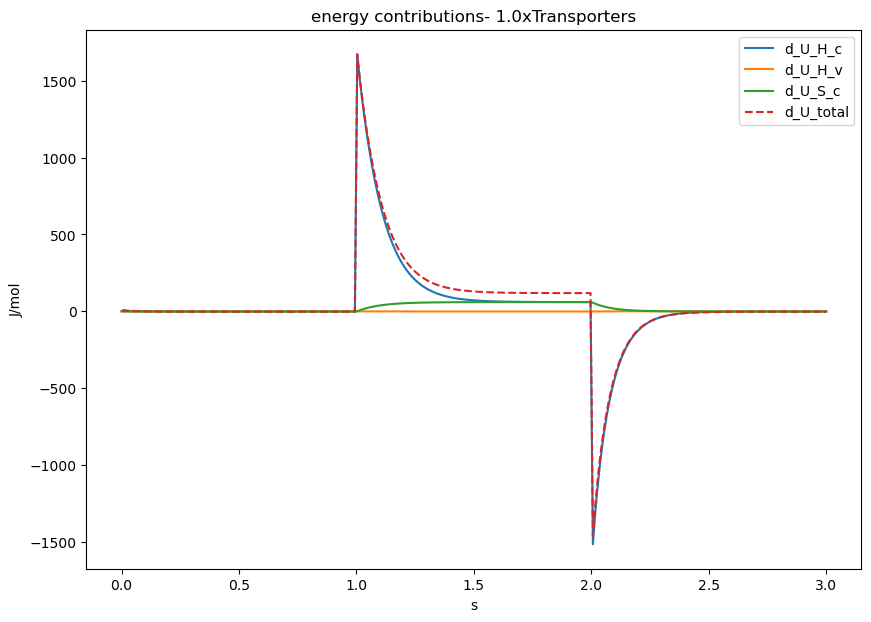

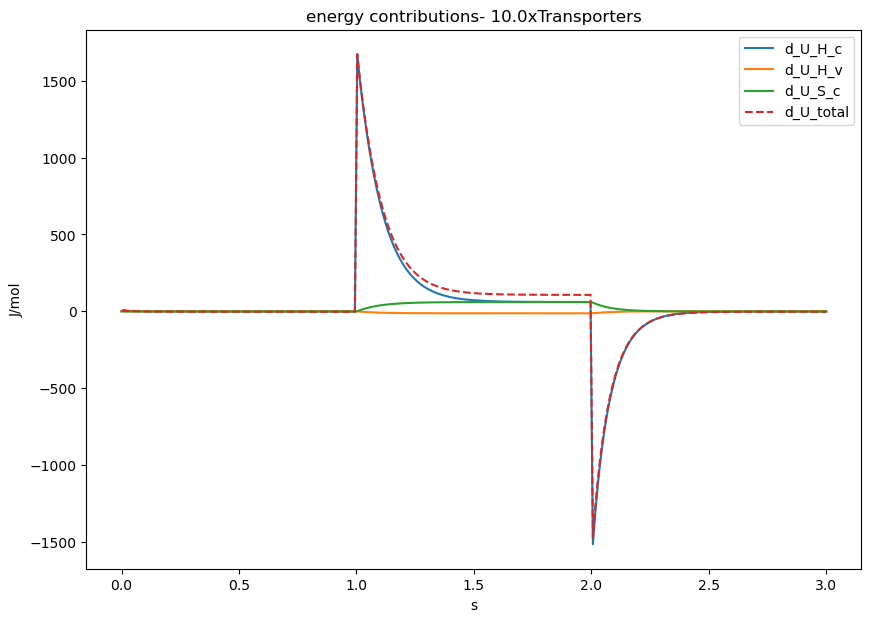

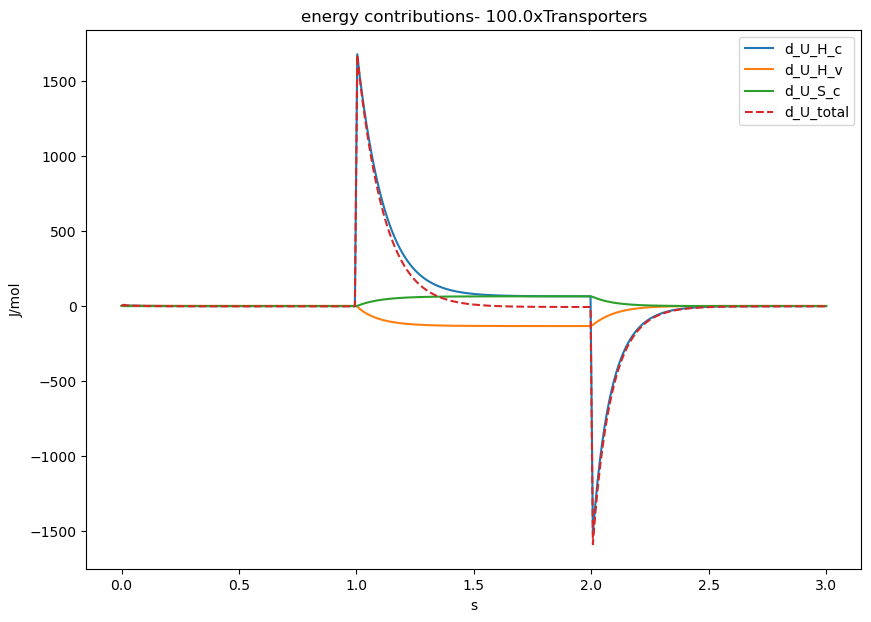

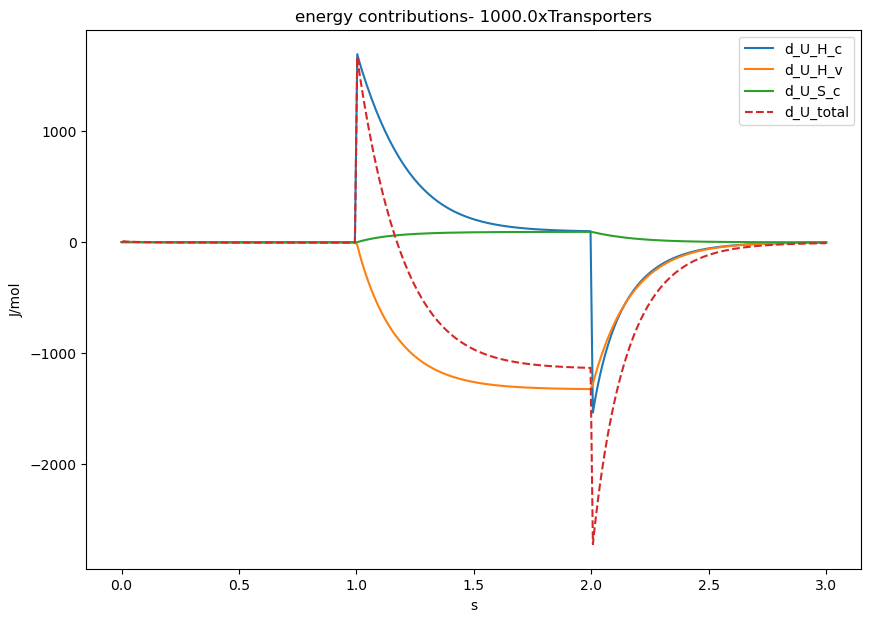

In [119]:
import tellurium as te
import matplotlib.pyplot as plt
import numpy as np
import antimony 
print(antimony.__version__)
from scipy.integrate import cumtrapz


def run_simulation(rr_model, selections, bias):
    rr_model.resetToOrigin()
    rr_model.integrator.absolute_tolerance = 1e-18
    rr_model.integrator.relative_tolerance = 1e-15
    if bias:
        rr_model.V_scale = bias

    
    # rr_model.Q_t_per_liposome = 0.0
    # rr_model.conc_H_out = 1e-7
    # rr_model.conc_S_out = 1e-3
    conc_transporters_lipo_0 = rr_model.conc_transporters_lipo_0
    rr_model.conc_OF = (0.1*conc_transporters_lipo_0)/6;  # start all proteins in the 'OF' state
    rr_model.conc_OF_Hb = (0.1*conc_transporters_lipo_0)/6; 
    rr_model.conc_IF_Hb = (0.1*conc_transporters_lipo_0)/6; 
    rr_model.conc_IF_Hb_Sb = (0.9*conc_transporters_lipo_0)/6;
    rr_model.conc_IF_Sb = (0.9*conc_transporters_lipo_0)/6;
    rr_model.conc_OF_Sb = (0.9*conc_transporters_lipo_0)/6;

    results_1 = rr_model.simulate(0,3,300, selections=selections)
    
    # rr_model.Q_t_per_liposome = 0.0
    # rr_model.conc_H_out = 1e-7
    # rr_model.conc_S_out = 1e-3
    # results_1 = rr_model.simulate(0,1,100, selections=selections)

    # rr_model.conc_H_out = 0.5e-7
    # rr_model.conc_S_out = 1e-3
    # results_2 = rr_model.simulate(1,2,100, selections=selections)

    # rr_model.conc_H_out = 1e-7
    # rr_model.conc_S_out = 1e-3
    # results_3 = rr_model.simulate(2,3,100, selections=selections)
    # results = np.transpose(np.vstack([results_1, results_2, results_3]))

    results = np.transpose(np.vstack([results_1]))
    return results


# rr_model2 = te.loada("/Users/georgeau/Desktop/GitHub/Bayesian_Transporter/new/models/antiporter_1_1_12D_cycle1_antimony.txt")
# selections2 = [ "time","I_t_total"]
# results2 = run_simulation(rr_model2, selections2, bias=None)
# plt.plot(results2[0][101:], results2[-1][101:], color='black', label='no voltage')
# print(results2[-1][101], results2[-1][201])



ant_file = "/Users/georgeau/Desktop/GitHub/Bayesian_Transporter/new/models/antiporter_1_1_12D_cycle1_antimony_voltage.txt"
selections = [ "time", 
              "I_t_total","Q_t_total", "V_t_per_liposome", 
              "rxn4_fwd", "rxn4_rev",
              "k4_f", "k4_r", 
              "conc_IF_Hb_Sb", "conc_IF_Sb", "conc_H_in", 
              "frac_d_U_H_c", "frac_d_U_H_v" , "frac_d_U_S_c", "frac_d_U_S_v", 
              "d_U_total", "d_U_H_c", "d_U_H_v", "d_U_S_c", 
              "k6_r", "k6_r_2", 
              'nernst'
              ]
rr_model = te.loada(ant_file)

print(rr_model.C_m_per_liposome)
print(rr_model.C_m_total)

test_vals = [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]

plt.figure(figsize=(10,7))

results = run_simulation(rr_model, selections, bias=1)
plt.title("I(t)")
plt.plot(results[0], results[1], alpha=0.75)
plt.plot(results[0], results[1]+np.random.normal(0,10**-10.5, np.size(results[1])), 'o', alpha=0.75)
Q = cumtrapz( results[1], dx=results[0][1]-results[0][0], initial=0)
print(np.max(np.abs(Q)))
plt.plot(Q)

plt.legend()
plt.ylabel('A')
plt.xlabel('s')



plt.figure(figsize=(10,7))
for i in test_vals:
    results = run_simulation(rr_model, selections, bias=i)
    plt.title("I(t)")
    plt.plot(results[0], results[1], alpha=0.75, label=f"I_total_{i}xV")
    plt.legend()
    plt.ylabel('A')
    plt.xlabel('s')
    print(f'{i}: {results[1][100]} {results[1][200]}')
    print(f'{i}: {rr_model.transporter_amount}')


plt.figure(figsize=(10,7))
for i in test_vals:
    results = run_simulation(rr_model, selections, bias=i)
    plt.title("Q(t)")
    plt.plot(results[0], results[2], ls='--', alpha=0.75, label=f"Q_t_per_liposome_{i}xV")
    plt.ylabel('C')
    plt.xlabel('s')
    plt.legend()

plt.figure(figsize=(10,7))
for i in test_vals:
    results = run_simulation(rr_model, selections, bias=i)
    plt.title("V(t)")
    plt.plot(results[0], results[3], ls='--', alpha=0.75, label=f"V_t_per_liposome_{i}xV")
    plt.ylabel('V')
    plt.xlabel('s')
    plt.legend()


# plt.figure()
# for i in [0.1, 1, 10, 100, 1000]:
#     results = run_simulation(rr_model, selections, bias=i)
#     plt.title("rxn4_fwd(t)")
#     plt.plot(results[0], results[4], ls='--', alpha=0.75, label=f"rxn4_fwd_{i}")
#     plt.legend()

# plt.figure()
# for i in [0.1, 1, 10, 100, 1000]:
#     results = run_simulation(rr_model, selections, bias=i)
#     plt.title("rxn4_rev(t)")
#     plt.plot(results[0], results[5], alpha=0.75, label=f"rxn4_rev_{i}")
#     plt.legend()

# plt.figure()
# for i in [0.1, 1, 10, 100, 1000]:
#     results = run_simulation(rr_model, selections, bias=i)
#     plt.title("rxn4(t)")
#     plt.plot(results[0], results[4]-results[5], alpha=0.75, label=f"rxn4_{i}")
#     plt.legend()

# plt.figure()
# for i in [0.1, 1, 10, 100, 1000]:
#     results = run_simulation(rr_model, selections, bias=i)
#     plt.title("k4_f(t)")
#     plt.plot(results[0], results[6], alpha=0.75, label=f"k4_f_{i}")
#     plt.legend()

# plt.figure()
# for i in [0.1, 1, 10, 100, 1000]:
#     results = run_simulation(rr_model, selections, bias=i)
#     plt.title("k4_r(t)")
#     plt.plot(results[0], results[7], alpha=0.75, label=f"k4_r_{i}")
#     plt.legend()

# plt.figure()
# for i in [0.1, 1, 10, 100, 1000]:
#     results = run_simulation(rr_model, selections, bias=i)
#     plt.title("conc_IF_Hb_Sb(t)")
#     plt.plot(results[0], results[8], alpha=0.75, label=f"conc_IF_Hb_Sb_{i}")
#     plt.legend()

# plt.figure()
# for i in [0.1, 1, 10, 100, 1000]:
#     results = run_simulation(rr_model, selections, bias=i)
#     plt.title("conc_IF_Sb(t)")
#     plt.plot(results[0], results[9], alpha=0.75, label=f"conc_IF_Sb_{i}")
#     plt.legend()

# plt.figure()
# for i in [0.1, 1, 10, 100, 1000]:
#     results = run_simulation(rr_model, selections, bias=i)
#     plt.title("conc_H_in(t)")
#     print()
#     plt.plot(results[0], results[10], alpha=0.75, label=f"conc_H_in_{i}")
#     plt.legend()

# plt.figure()
# for i in [0.1, 1, 10, 100, 1000]:
#     results = run_simulation(rr_model, selections, bias=i)
#     H_in_temp = results[10]
#     t = np.arange(len(H_in_temp))/100
#     dt = t[1]-t[0]
#     dH_dt = np.gradient(H_in_temp,dt)
#     plt.title("d conc_H_in(t)/dt")
#     plt.plot(results[0], dH_dt, alpha=0.75, label=f"d_conc_H_in_dt_{i}")
#     plt.legend()


# for i in [1]:
#     plt.figure()
#     results = run_simulation(rr_model, selections, bias=i)
#     frac_d_U_H_c = results[11]
#     frac_d_U_H_v = results[12]
#     frac_d_U_S_c = results[13]
#     frac_d_U_S_v = results[14]
#     d_U_total = results[15]
#     t = np.arange(len(d_U_total))/100
#     plt.title(f"fractional energy contributions - voltage scaled by {i}x")
#     plt.stackplot(t[100:], frac_d_U_H_c[100:], frac_d_U_H_v[100:], frac_d_U_S_c[100:], frac_d_U_S_v[100:], labels=['frac_d_U_H_c', 'frac_d_U_H_v', 'frac_d_U_S_c', 'frac_d_U_S_v'])
#     plt.ylim(-0.25, 1.25)
#     plt.legend()

for i in test_vals:
    plt.figure(figsize=(10,7))
    results = run_simulation(rr_model, selections, bias=i)
    d_U_total = results[15]
    d_U_H_c = results[16]
    d_U_H_v = results[17]
    d_U_S_c = results[18]
    t = results[0]
    plt.title(f"energy contributions- {i}xTransporters")
    plt.plot(t,d_U_H_c,label='d_U_H_c' )
    plt.plot(t,d_U_H_v,label='d_U_H_v' )
    plt.plot(t,d_U_S_c,label='d_U_S_c' )
    plt.plot(t,d_U_total,label='d_U_total', ls='--' )
    plt.ylabel('J/mol')
    plt.xlabel('s')
    plt.legend()

# for i in [1, 1000]:
#     plt.figure()
#     results = run_simulation(rr_model, selections, bias=i)
#     k6_f_v1 = results[19]
#     k6_f_v2 = results[20]
#     t = np.arange(len(k6_f_v1))/100
#     plt.title(f"rate constant constraint comparison - voltage scaled by {i}x")
#     plt.plot(t,k6_f_v1,label='k6_f_v1' )
#     plt.plot(t,k6_f_v2,label='k6_f_v2' )
#     plt.legend()

# for i in [1, 100]:
#     plt.figure()
#     results = run_simulation(rr_model, selections, bias=i)
#     v = results[3]
#     v_nernst = results[21]
#     t = np.arange(len(v))/100
#     plt.title(f"potential - voltage scaled by {i}x")
#     plt.plot(t,v,label='v' )
#     plt.plot(t,v_nernst,label='v_nernst' )
#     plt.legend()




In [ ]:
import tellurium as te 
import numpy as np 
import matplotlib.pyplot as plt

ant_str = """
model example()

species conc_A = 100; 
species conc_B = 0;
const k1_f = 10;
const k1_r = 1;
rxn1: conc_A -> conc_B; (k1_f*conc_A - k1_r*conc_B);
var vol = 1e-3;
var alpha = 96472.44;
var I := alpha*vol*rxn1;
var Q = 0;
Q' = I;
end
"""

rr_model = te.loada(ant_str)
results = rr_model.simulate(0,1,100, selections=['time', 'conc_A', 'conc_B', 'I', 'Q'])
plt.figure()
plt.plot(results['time'], results['conc_A'])
plt.plot(results['time'], results['conc_B'])

plt.figure()
plt.plot(results['time'], results['I'])
plt.plot(results['time'], results['Q'])

In [121]:
import numpy as np

F = 96485.33212  # Faraday constant, C/mol
R = 8.314  # Gas constant, J/(mol*K)
T = 298.15  # Temperature, K


V = 100 * 10**-6  # Voltage, V (converted from microvolts to volts)

result = np.exp(-V * F / (R * T))

print(result)

0.9961151745119415


In [ ]:

import matplotlib.pyplot as plt

# List to store the results
n_components = range(1, 10)  # Change range as necessary
aics = []
bics = []
samples = np.loadtxt()

# Fit GMMs with different numbers of components
for n in n_components:
    gmm = GaussianMixture(n_components=n)
    gmm.fit(samples)
    aics.append(gmm.aic(samples))
    bics.append(gmm.bic(samples))

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(n_components, aics, label='AIC')
plt.plot(n_components, bics, label='BIC')
plt.legend()
plt.xlabel('Number of Components')
plt.ylabel('Information Criterion')
plt.show()


In [76]:
print(np.sqrt(2000))

44.721359549995796
